# SWB Computational Models

- Winning model from 2014 "A computational and neural model of momentary subjective well-being"
- Adapted to include counterfactual information 

Created: 05/04/2023 by Alie Fink

### Computational Models:
Standard GLMs:
1) RPE (CR+EV+RPE)
2) Counterfactual (CR+EV+CPE) *test tCPE vs dCPE
3) Counterfactual+RPE (CR+EV+RPE+CPE)
4) Regret (CR+EV+nCPE) *omit RPE if model 2 > model 3
5) Relief (CR+EV+pCPE) *omit RPE if model 2 > model 3
6) Regret/Relief (CR+EV+nCPE+pCPE) *omit RPE if model 2 > model 3
7) Full model (CR+EV+RPE+nCPE+pCPE)

Prospect Theory GLMs:

8)  Rutledge EV (CR+EV)
9)  PT (Util_s+Util_g) *validate this is better than Rutledge EV
10) RPE PT (Util_s+Util_g+RPE)
11) CPE PT (Util_s+Util_g+CPE) *test tCPE vs dCPE 
12) CPE+RPE PT (Util_s+Util_g+RPE+CPE) 
13) Regret PT (Util_s+Util_g+RPE+nCPE) *omit RPE if model 9 > model 8
14) Relief PT (Util_s+Util_g+RPE+pCPE) *omit RPE if model 9 > model 8
15) Regret/Relief PT (Util_s+Util_g+RPE+nCPE+pCPE) *omit RPE if model 9 > model 8


In [2]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
import scipy
from scipy.optimize import least_squares
import sklearn
from sklearn.metrics import r2_score
import random


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [4]:
import sys
sys.path.append('/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/swb_computational_modeling/swb_behav_models/scripts/')
import SWB_modeling_utils

In [5]:
swb_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/'
subj_list = pd.read_excel(f'{swb_dir}SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[0])
subj_ids = list(subj_list.PatientID)

## Standard GLMs

Step 1: Choose winning model from 1-4 (RPE+CPE or CPE only & tCPE vs dCPE)

1) RPE (CR+EV+RPE)
2) tCPE (CR+EV+tCPE) 
3) dCPE (CR+EV+dCPE) 
4) tCPE+RPE (CR+EV+RPE+tCPE)
5) dCPE+RPE  (CR+EV+RPE+dCPE)

Step 2: Choose winning model from 6-11

6) total Regret (CR+EV+tRegret) *omit RPE if model 2 > model 1
7) decision Regret (CR+EV+dRegret) *omit RPE if model 2 > model 1
8) total Relief (CR+EV+tRelief) *omit RPE if model 2 > model 1
9) decision Relief (CR+EV+dRelief) *omit RPE if model 2 > model 1
10) total Regret/Relief (CR+EV+tRegret+tRelief) *omit RPE if model 2 > model 1
11) decision Regret/Relief (CR+EV+dRegret+dRelief) *omit RPE if model 2 > model 1

In [30]:
model_input_path = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/swb_computational_modeling/swb_behav_models/data/pt_model_input_data_06232023'
model_input = pd.read_csv(model_input_path)
date = '06232023'

In [26]:
model_input.columns

Index(['subj_id', 'round', 'rate', 'zscore_rate', 'cr(t-1)', 'cr(t-2)',
       'cr(t-3)', 'choice_ev(t-1)', 'choice_ev(t-2)', 'choice_ev(t-3)',
       'rpe(t-1)', 'rpe(t-2)', 'rpe(t-3)', 'totalcpe(t-1)', 'totalcpe(t-2)',
       'totalcpe(t-3)', 'decisioncpe(t-1)', 'decisioncpe(t-2)',
       'decisioncpe(t-3)', 'totalregret(t-1)', 'totalregret(t-2)',
       'totalregret(t-3)', 'decisionregret(t-1)', 'decisionregret(t-2)',
       'decisionregret(t-3)', 'totalrelief(t-1)', 'totalrelief(t-2)',
       'totalrelief(t-3)', 'decisionrelief(t-1)', 'decisionrelief(t-2)',
       'decisionrelief(t-3)', 'util_g(t-1)', 'util_g(t-2)', 'util_g(t-3)',
       'util_s(t-1)', 'util_s(t-2)', 'util_s(t-3)'],
      dtype='object')

### Step 1: Choose winning model from 1-4 (RPE+CPE or CPE only & tCPE vs dCPE)
- Include RPE in CPE models?
- Is total CPE or decision CPE a better CPE metric (total = outcome - max possible, decision = outcome - max unchosen)

In [27]:
model1_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","rpe(t-1)","rpe(t-2)","rpe(t-3)"]
model2_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","totalcpe(t-1)","totalcpe(t-2)","totalcpe(t-3)"]
model3_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","decisioncpe(t-1)","decisioncpe(t-2)","decisioncpe(t-3)"]
model4_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","rpe(t-1)","rpe(t-2)","rpe(t-3)","totalcpe(t-1)","totalcpe(t-2)","totalcpe(t-3)"]
model5_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","rpe(t-1)","rpe(t-2)","rpe(t-3)","decisioncpe(t-1)","decisioncpe(t-2)","decisioncpe(t-3)"]


In [28]:
models_dict = {}
models_dict['rpe'] = model1_vars
models_dict['tcpe'] = model2_vars
models_dict['dcpe'] = model3_vars
models_dict['rpe+tcpe'] = model4_vars
models_dict['rpe+dcpe'] = model5_vars


In [29]:
#### run swb to find optimal parameters 
models_list = ['rpe','tcpe','dcpe','rpe+tcpe','rpe+dcpe']
lam_method = 'exp'

step1_results = {}

for model in models_list:

    reg_list = models_dict[model]
    n_regs = int(len(reg_list)/3)

    mood_est_df, optim_resid_df, optim_inits_df, param_fits_df, aic_dict,bic1_dict,bic2_dict, rsq_dict = \
    SWB_modeling_utils.run_swb(model_input, subj_ids, n_regs, reg_list,lam_method)
    

    step1_results[model] = {'mood_est': mood_est_df,
                            'optim_residuals':optim_resid_df,
                           'optim_inits': optim_inits_df,
                           'param_fits': param_fits_df,
                            'aics':aic_dict,
                           'bics1': bic1_dict,
                            'bics2': bic2_dict,
                           'rsqs': rsq_dict
                           }



In [31]:
### use optimal parameters to run model 

models_list = ['rpe','tcpe','dcpe','rpe+tcpe','rpe+dcpe']
lam_method = 'exp'

step1_data = {}

for model in models_list:

    reg_list = models_dict[model]
    n_regs = int(len(reg_list)/3)
    params = step1_results[model]['param_fits']

    mood_est_df, resid_df, rss_dict, aic_dict, bic1_dict, bic2_dict, rsq_dict = \
    SWB_modeling_utils.fit_swb(model_input,subj_ids,params,n_regs,reg_list,lam_method)
    

    step1_data[model] = {'mood_est': mood_est_df,
                            'residuals':resid_df,
                           'rss': rss_dict,
                            'aic':aic_dict,
                           'bics1': bic1_dict,
                            'bics2': bic2_dict,
                           'rsqs': rsq_dict
                           }


In [32]:
for ix,s in enumerate(subj_ids):
    best_bic = np.inf
    best_rsq = -np.inf
    best_model_bic = []
    best_model_rsq = []
    for model in models_list:
        bic = step1_data[model]['bics1'][s]
        rsq = step1_data[model]['rsqs'][s]
        if bic<best_bic:
            best_bic = bic 
            best_model_bic = model
        if rsq>best_rsq:
            best_rsq=rsq
            best_model_rsq = model
        
    print('best model bic for ',s,'is',best_model_bic,best_bic)
    print('best model rsq for ',s,'is',best_model_rsq,best_rsq)

best model bic for  DA8 is tcpe -87.26049994458361
best model rsq for  DA8 is tcpe -0.13666778229933207
best model bic for  DA9 is rpe -144.75489472900932
best model rsq for  DA9 is rpe -0.057844122807082066
best model bic for  DA10 is rpe -154.9474037353115
best model rsq for  DA10 is rpe+tcpe -0.042730487865407785
best model bic for  DA11 is rpe -234.0190723037698
best model rsq for  DA11 is rpe+tcpe 0.05389275799691218
best model bic for  DA023 is rpe -212.82425859504133
best model rsq for  DA023 is rpe+dcpe 0.035261493135972266
best model bic for  MS002 is tcpe -227.9465020394386
best model rsq for  MS002 is tcpe 0.0466341142204697
best model bic for  MS003 is rpe -233.46913137536512
best model rsq for  MS003 is rpe 0.0531928079135513
best model bic for  MS016 is rpe -262.3093757537949
best model rsq for  MS016 is rpe 0.08671757661373536
best model bic for  MS017 is rpe -152.0359514796624
best model rsq for  MS017 is rpe -0.04826002407929497
best model bic for  MS019 is rpe+tcpe -2

In [33]:
print('model 1 bic1 mean',np.mean(np.array(list(step1_data['rpe']['bics1'].values()))))
print('model 2 bic1 mean',np.mean(np.array(list(step1_data['tcpe']['bics1'].values()))))
print('model 3 bic1 mean',np.mean(np.array(list(step1_data['dcpe']['bics1'].values()))))
print('model 4 bic1 mean',np.mean(np.array(list(step1_data['rpe+tcpe']['bics1'].values()))))
print('model 5 bic1 mean',np.mean(np.array(list(step1_data['rpe+dcpe']['bics1'].values()))))

model 1 bic1 mean -146.16380252708785
model 2 bic1 mean -164.99133111392706
model 3 bic1 mean -132.51081809563257
model 4 bic1 mean -122.60727732912494
model 5 bic1 mean -113.86157171812305


In [34]:
print('model 1 bic1 sum',np.sum(np.array(list(step1_data['rpe']['bics1'].values()))))
print('model 2 bic1 sum',np.sum(np.array(list(step1_data['tcpe']['bics1'].values()))))
print('model 3 bic1 sum',np.sum(np.array(list(step1_data['dcpe']['bics1'].values()))))
print('model 4 bic1 sum',np.sum(np.array(list(step1_data['rpe+tcpe']['bics1'].values()))))
print('model 5 bic1 sum',np.sum(np.array(list(step1_data['rpe+dcpe']['bics1'].values()))))

model 1 bic1 sum -2338.6208404334056
model 2 bic1 sum -2639.861297822833
model 3 bic1 sum -2120.173089530121
model 4 bic1 sum -1961.716437265999
model 5 bic1 sum -1821.7851474899687


In [35]:
print('model 1 bic2 mean',np.mean(np.array(list(step1_data['rpe']['bics2'].values()))))
print('model 2 bic2 mean',np.mean(np.array(list(step1_data['tcpe']['bics2'].values()))))
print('model 3 bic2 mean',np.mean(np.array(list(step1_data['dcpe']['bics2'].values()))))
print('model 4 bic2 mean',np.mean(np.array(list(step1_data['rpe+tcpe']['bics2'].values()))))
print('model 5 bic2 mean',np.mean(np.array(list(step1_data['rpe+dcpe']['bics2'].values()))))

model 1 bic2 mean 33.8720257912532
model 2 bic2 mean 33.9190946127203
model 3 bic2 mean 33.837893330174566
model 4 bic2 mean 40.514457735245394
model 5 bic2 mean 40.49259347121789


In [36]:
print('model 1 bic2 sum',np.sum(np.array(list(step1_data['rpe']['bics2'].values()))))
print('model 2 bic2 sum',np.sum(np.array(list(step1_data['tcpe']['bics2'].values()))))
print('model 3 bic2 sum',np.sum(np.array(list(step1_data['dcpe']['bics2'].values()))))
print('model 4 bic2 sum',np.sum(np.array(list(step1_data['rpe+tcpe']['bics2'].values()))))
print('model 5 bic2 sum',np.sum(np.array(list(step1_data['rpe+dcpe']['bics2'].values()))))

model 1 bic2 sum 541.9524126600512
model 2 bic2 sum 542.7055138035248
model 3 bic2 sum 541.4062932827931
model 4 bic2 sum 648.2313237639263
model 5 bic2 sum 647.8814955394862


In [37]:
print('model 1 aic mean',np.mean(np.array(list(step1_data['rpe']['aic'].values()))))
print('model 2 aic mean',np.mean(np.array(list(step1_data['tcpe']['aic'].values()))))
print('model 3 aic mean',np.mean(np.array(list(step1_data['dcpe']['aic'].values()))))
print('model 4 aic mean',np.mean(np.array(list(step1_data['rpe+tcpe']['aic'].values()))))
print('model 5 aic mean',np.mean(np.array(list(step1_data['rpe+dcpe']['aic'].values()))))


model 1 aic mean -169.58686116542748
model 2 aic mean -188.4143897522667
model 3 aic mean -155.9338767339722
model 4 aic mean -150.71494769513254
model 5 aic mean -141.9692420841306


In [38]:
print('model 1 aic sum',np.sum(np.array(list(step1_data['rpe']['aic'].values()))))
print('model 2 aic sum',np.sum(np.array(list(step1_data['tcpe']['aic'].values()))))
print('model 3 aic sum',np.sum(np.array(list(step1_data['dcpe']['aic'].values()))))
print('model 4 aic sum',np.sum(np.array(list(step1_data['rpe+tcpe']['aic'].values()))))
print('model 5 aic sum',np.sum(np.array(list(step1_data['rpe+dcpe']['aic'].values()))))


model 1 aic sum -2713.3897786468397
model 2 aic sum -3014.630236036267
model 3 aic sum -2494.942027743555
model 4 aic sum -2411.4391631221206
model 5 aic sum -2271.5078733460896


In [39]:
print('model 1 rsq mean',np.mean(np.array(list(step1_data['rpe']['rsqs'].values()))))
print('model 2 rsq mean',np.mean(np.array(list(step1_data['tcpe']['rsqs'].values()))))
print('model 3 rsq mean',np.mean(np.array(list(step1_data['dcpe']['rsqs'].values()))))
print('model 4 rsq mean',np.mean(np.array(list(step1_data['rpe+tcpe']['rsqs'].values()))))
print('model 5 rsq mean',np.mean(np.array(list(step1_data['rpe+dcpe']['rsqs'].values()))))


model 1 rsq mean -0.07639747350634138
model 2 rsq mean -0.033264899625555594
model 3 rsq mean -0.0791317184496362
model 4 rsq mean -0.0989080896099136
model 5 rsq mean -0.11510586620152455


In [40]:
print('model 1 rsq sum',np.sum(np.array(list(step1_data['rpe']['rsqs'].values()))))
print('model 2 rsq sum',np.sum(np.array(list(step1_data['tcpe']['rsqs'].values()))))
print('model 3 rsq sum',np.sum(np.array(list(step1_data['dcpe']['rsqs'].values()))))
print('model 4 rsq sum',np.sum(np.array(list(step1_data['rpe+tcpe']['rsqs'].values()))))
print('model 5 rsq sum',np.sum(np.array(list(step1_data['rpe+dcpe']['rsqs'].values()))))

model 1 rsq sum -1.222359576101462
model 2 rsq sum -0.5322383940088895
model 3 rsq sum -1.2661074951941793
model 4 rsq sum -1.5825294337586175
model 5 rsq sum -1.8416938592243928


### Results of step 1: 
- adding RPE adds explanatory power to the model but worsens BIC
- total CPE is better

### Step 2: Choose winning regret/relief model
- total vs decision regret/relief
- regret or relief?

In [41]:
model6_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","totalregret(t-1)","totalregret(t-2)","totalregret(t-3)"]
model7_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","decisionregret(t-1)","decisionregret(t-2)","decisionregret(t-3)"]
model8_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","totalrelief(t-1)","totalrelief(t-2)","totalrelief(t-3)"]
model9_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","decisionrelief(t-1)","decisionrelief(t-2)","decisionrelief(t-3)"]
model10_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","totalregret(t-1)","totalregret(t-2)","totalregret(t-3)","totalrelief(t-1)","totalrelief(t-2)","totalrelief(t-3)"]
model11_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","decisionregret(t-1)","decisionregret(t-2)","decisionregret(t-3)","decisionrelief(t-1)","decisionrelief(t-2)","decisionrelief(t-3)"]

In [42]:
models_dict['treg'] = model6_vars
models_dict['dreg'] = model7_vars
models_dict['trel'] = model8_vars
models_dict['drel'] = model9_vars
models_dict['treg/rel'] = model10_vars
models_dict['dreg/rel'] = model11_vars


In [43]:
models_list2 = ['treg','dreg','trel','drel','treg/rel','dreg/rel']
lam_method = 'exp'

step2_results = {}

for model in models_list2:

    reg_list = models_dict[model]
    n_regs = int(len(reg_list)/3)

    mood_est_df, optim_resid_df, optim_inits_df, param_fits_df, aic_dict,bic1_dict,bic2_dict, rsq_dict = \
    SWB_modeling_utils.run_swb(model_input, subj_ids, n_regs, reg_list,lam_method)
    

    step2_results[model] = {'mood_est': mood_est_df,
                            'optim_residuals':optim_resid_df,
                           'optim_inits': optim_inits_df,
                           'param_fits': param_fits_df,
                            'aics':aic_dict,
                           'bics1': bic1_dict,
                            'bics2': bic2_dict,
                           'rsqs': rsq_dict
                           }



In [44]:
### use optimal parameters to run model 

models_list2 = ['treg','dreg','trel','drel','treg/rel','dreg/rel']
lam_method = 'exp'

step2_data = {}

for model in models_list2:

    reg_list = models_dict[model]
    n_regs = int(len(reg_list)/3)
    params = step2_results[model]['param_fits']

    mood_est_df, resid_df, rss_dict, aic_dict, bic1_dict, bic2_dict, rsq_dict = \
    SWB_modeling_utils.fit_swb(model_input,subj_ids,params,n_regs,reg_list,lam_method)
    

    step2_data[model] = {'mood_est': mood_est_df,
                            'residuals':resid_df,
                           'rss': rss_dict,
                            'aic':aic_dict,
                           'bics1': bic1_dict,
                            'bics2': bic2_dict,
                           'rsqs': rsq_dict
                           }


In [45]:
for ix,s in enumerate(subj_ids):
    best_bic = np.inf
    best_rsq = -np.inf
    best_model_bic = []
    best_model_rsq = []
    for model in models_list2:
        bic = step2_data[model]['bics1'][s]
        rsq = step2_data[model]['rsqs'][s]
        if bic<best_bic:
            best_bic = bic 
            best_model_bic = model
        if rsq>best_rsq:
            best_rsq=rsq
            best_model_rsq = model
        
    print('best model bic for ',s,'is',best_model_bic,best_bic)
    print('best model rsq for ',s,'is',best_model_rsq,best_rsq)

best model bic for  DA8 is treg -52.99556877035673
best model rsq for  DA8 is treg/rel -0.18020219247640235
best model bic for  DA9 is treg -169.1054677591245
best model rsq for  DA9 is treg -0.02613033860095082
best model bic for  DA10 is treg/rel -149.3732242989954
best model rsq for  DA10 is treg/rel -0.04300327293977424
best model bic for  DA11 is treg -239.1332516721581
best model rsq for  DA11 is treg 0.05987267008725272
best model bic for  DA023 is trel -228.04571443697887
best model rsq for  DA023 is trel 0.04675233903353959
best model bic for  MS002 is treg/rel -253.68422363293618
best model rsq for  MS002 is treg/rel 0.08449956081679022
best model bic for  MS003 is treg -236.96156504995668
best model rsq for  MS003 is treg/rel 0.06203036865100231
best model bic for  MS016 is treg/rel -252.3673016660654
best model rsq for  MS016 is treg/rel 0.08299126641732357
best model bic for  MS017 is treg/rel -165.51358552766345
best model rsq for  MS017 is treg/rel -0.022171067172758407


In [46]:
print('model 6 bic1 mean',np.mean(np.array(list(step2_data['treg']['bics1'].values()))))
print('model 7 bic1 mean',np.mean(np.array(list(step2_data['dreg']['bics1'].values()))))
print('model 8 bic1 mean',np.mean(np.array(list(step2_data['trel']['bics1'].values()))))
print('model 9 bic1 mean',np.mean(np.array(list(step2_data['drel']['bics1'].values()))))
print('model 10 bic1 mean',np.mean(np.array(list(step2_data['treg/rel']['bics1'].values()))))
print('model 11 bic1 mean',np.mean(np.array(list(step2_data['dreg/rel']['bics1'].values()))))

model 6 bic1 mean -167.39208822657372
model 7 bic1 mean -145.20275757488886
model 8 bic1 mean -135.48170330162299
model 9 bic1 mean -134.4724579839558
model 10 bic1 mean -157.04033122784892
model 11 bic1 mean -137.93141186974086


In [47]:
print('model 6 bic1 sum',np.sum(np.array(list(step2_data['treg']['bics1'].values()))))
print('model 7 bic1 sum',np.sum(np.array(list(step2_data['dreg']['bics1'].values()))))
print('model 8 bic1 sum',np.sum(np.array(list(step2_data['trel']['bics1'].values()))))
print('model 9 bic1 sum',np.sum(np.array(list(step2_data['drel']['bics1'].values()))))
print('model 10 bic1 sum',np.sum(np.array(list(step2_data['treg/rel']['bics1'].values()))))
print('model 11 bic1 sum',np.sum(np.array(list(step2_data['dreg/rel']['bics1'].values()))))

model 6 bic1 sum -2678.2734116251795
model 7 bic1 sum -2323.244121198222
model 8 bic1 sum -2167.7072528259678
model 9 bic1 sum -2151.5593277432927
model 10 bic1 sum -2512.645299645583
model 11 bic1 sum -2206.9025899158537


In [48]:
print('model 6 bic2 mean',np.mean(np.array(list(step2_data['treg']['bics2'].values()))))
print('model 7 bic2 mean',np.mean(np.array(list(step2_data['dreg']['bics2'].values()))))
print('model 8 bic2 mean',np.mean(np.array(list(step2_data['trel']['bics2'].values()))))
print('model 9 bic2 mean',np.mean(np.array(list(step2_data['drel']['bics2'].values()))))
print('model 10 bic2 mean',np.mean(np.array(list(step2_data['treg/rel']['bics2'].values()))))
print('model 11 bic2 mean',np.mean(np.array(list(step2_data['dreg/rel']['bics2'].values()))))

model 6 bic2 mean 33.92509650550191
model 7 bic2 mean 33.8696231788727
model 8 bic2 mean 33.845320543189544
model 9 bic2 mean 33.84279742989538
model 10 bic2 mean 40.6005403699922
model 11 bic2 mean 40.55276807159693


In [49]:
print('model 6 bic2 sum',np.sum(np.array(list(step2_data['treg']['bics2'].values()))))
print('model 7 bic2 sum',np.sum(np.array(list(step2_data['dreg']['bics2'].values()))))
print('model 8 bic2 sum',np.sum(np.array(list(step2_data['trel']['bics2'].values()))))
print('model 9 bic2 sum',np.sum(np.array(list(step2_data['drel']['bics2'].values()))))
print('model 10 bic2 sum',np.sum(np.array(list(step2_data['treg/rel']['bics2'].values()))))
print('model 11 bic2 sum',np.sum(np.array(list(step2_data['dreg/rel']['bics2'].values()))))

model 6 bic2 sum 542.8015440880306
model 7 bic2 sum 541.9139708619632
model 8 bic2 sum 541.5251286910327
model 9 bic2 sum 541.484758878326
model 10 bic2 sum 649.6086459198752
model 11 bic2 sum 648.8442891455509


In [50]:
print('model 6 aic mean',np.mean(np.array(list(step2_data['treg']['aic'].values()))))
print('model 7 aic mean',np.mean(np.array(list(step2_data['dreg']['aic'].values()))))
print('model 8 aic mean',np.mean(np.array(list(step2_data['trel']['aic'].values()))))
print('model 9 aic mean',np.mean(np.array(list(step2_data['drel']['aic'].values()))))
print('model 10 aic mean',np.mean(np.array(list(step2_data['treg/rel']['aic'].values()))))
print('model 11 aic mean',np.mean(np.array(list(step2_data['dreg/rel']['aic'].values()))))


model 6 aic mean -190.81514686491334
model 7 aic mean -168.6258162132285
model 8 aic mean -158.9047619399626
model 9 aic mean -157.89551662229545
model 10 aic mean -185.14800159385646
model 11 aic mean -166.03908223574842


In [51]:
print('model 6 aic sum',np.sum(np.array(list(step2_data['treg']['aic'].values()))))
print('model 7 aic sum',np.sum(np.array(list(step2_data['dreg']['aic'].values()))))
print('model 8 aic sum',np.sum(np.array(list(step2_data['trel']['aic'].values()))))
print('model 9 aic sum',np.sum(np.array(list(step2_data['drel']['aic'].values()))))
print('model 10 aic sum',np.sum(np.array(list(step2_data['treg/rel']['aic'].values()))))
print('model 11 aic sum',np.sum(np.array(list(step2_data['dreg/rel']['aic'].values()))))


model 6 aic sum -3053.0423498386135
model 7 aic sum -2698.013059411656
model 8 aic sum -2542.476191039402
model 9 aic sum -2526.328265956727
model 10 aic sum -2962.3680255017034
model 11 aic sum -2656.625315771975


In [52]:
print('model 6 rsq mean',np.mean(np.array(list(step2_data['treg']['rsqs'].values()))))
print('model 7 rsq mean',np.mean(np.array(list(step2_data['dreg']['rsqs'].values()))))
print('model 8 rsq mean',np.mean(np.array(list(step2_data['trel']['rsqs'].values()))))
print('model 9 rsq mean',np.mean(np.array(list(step2_data['drel']['rsqs'].values()))))
print('model 10 rsq mean',np.mean(np.array(list(step2_data['treg/rel']['rsqs'].values()))))
print('model 11 rsq mean',np.mean(np.array(list(step2_data['dreg/rel']['rsqs'].values()))))


model 6 rsq mean -0.03209821837195725
model 7 rsq mean -0.0609207866044603
model 8 rsq mean -0.07823537892210636
model 9 rsq mean -0.07992115192349766
model 10 rsq mean -0.03893873779987825
model 11 rsq mean -0.061676584624790004


In [53]:
print('model 6 rsq sum',np.sum(np.array(list(step2_data['treg']['rsqs'].values()))))
print('model 7 rsq sum',np.sum(np.array(list(step2_data['dreg']['rsqs'].values()))))
print('model 8 rsq sum',np.sum(np.array(list(step2_data['trel']['rsqs'].values()))))
print('model 9 rsq sum',np.sum(np.array(list(step2_data['drel']['rsqs'].values()))))
print('model 10 rsq sum',np.sum(np.array(list(step2_data['treg/rel']['rsqs'].values()))))
print('model 11 rsq sum',np.sum(np.array(list(step2_data['dreg/rel']['rsqs'].values()))))

model 6 rsq sum -0.513571493951316
model 7 rsq sum -0.9747325856713648
model 8 rsq sum -1.2517660627537017
model 9 rsq sum -1.2787384307759626
model 10 rsq sum -0.623019804798052
model 11 rsq sum -0.9868253539966401


### Results of step 2
- best fit is total regret (consistent with step 1 results that total calculation is best)
- regret is overall a better fit than relief
- adding total regret & total relief together out performs relief alone 

### Step 3: Summary of basic GLMs
Finalize - 

1) RPE (CR+EV+RPE)
2) Counterfactual (CR+EV+tCPE) 
3) Counterfactual+RPE (CR+EV+RPE+tCPE)
4) Regret (CR+EV+regret) 
5) Relief (CR+EV+relief)
6) Regret/Relief (CR+EV+regret+relief)
7) Full model (CR+EV+RPE+regret+relief)


In [54]:
glm1_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","rpe(t-1)","rpe(t-2)","rpe(t-3)"]
glm2_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","totalcpe(t-1)","totalcpe(t-2)","totalcpe(t-3)"]
glm3_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","rpe(t-1)","rpe(t-2)","rpe(t-3)","totalcpe(t-1)","totalcpe(t-2)","totalcpe(t-3)"]
glm4_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","totalregret(t-1)","totalregret(t-2)","totalregret(t-3)"]
glm5_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","totalrelief(t-1)","totalrelief(t-2)","totalrelief(t-3)"]
glm6_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","totalregret(t-1)","totalregret(t-2)","totalregret(t-3)","totalrelief(t-1)","totalrelief(t-2)","totalrelief(t-3)"]
glm7_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","rpe(t-1)","rpe(t-2)","rpe(t-3)","totalregret(t-1)","totalregret(t-2)","totalregret(t-3)","totalrelief(t-1)","totalrelief(t-2)","totalrelief(t-3)"]


In [55]:
glms_dict = {}
glms_dict['RPE'] = glm1_vars
glms_dict['CPE'] = glm2_vars
glms_dict['CPE+RPE'] = glm3_vars
glms_dict['Regret'] = glm4_vars
glms_dict['Relief'] = glm5_vars
glms_dict['Regret+Relief'] = glm6_vars
glms_dict['Full'] = glm7_vars

In [56]:
glms_list = ['RPE','CPE','CPE+RPE','Regret','Relief','Regret+Relief','Full']
lam_method = 'exp'
glm_results = {}

for model in glms_list:

    reg_list = glms_dict[model]
    n_regs = int(len(reg_list)/3)

    mood_est_df, optim_resid_df, optim_inits_df, param_fits_df, aic_dict,bic1_dict,bic2_dict, rsq_dict = \
    SWB_modeling_utils.run_swb(model_input, subj_ids, n_regs, reg_list,lam_method)
    

    glm_results[model] = {'mood_est': mood_est_df,
                            'optim_residuals':optim_resid_df,
                           'optim_inits': optim_inits_df,
                           'param_fits': param_fits_df,
                            'aics':aic_dict,
                           'bics1': bic1_dict,
                            'bics2': bic2_dict,
                           'rsqs': rsq_dict
                           }


In [57]:
### use optimal parameters to run model 

glms_list = ['RPE','CPE','CPE+RPE','Regret','Relief','Regret+Relief','Full']
lam_method = 'exp'
glm_data = {}

for model in glms_list:

    reg_list = glms_dict[model]
    n_regs = int(len(reg_list)/3)
    params = glm_results[model]['param_fits']

    mood_est_df, resid_df, rss_dict, aic_dict, bic1_dict, bic2_dict, rsq_dict = \
    SWB_modeling_utils.fit_swb(model_input,subj_ids,params,n_regs,reg_list,lam_method)
    

    glm_data[model] = {'mood_est': mood_est_df,
                            'residuals':resid_df,
                           'rss': rss_dict,
                            'aic':aic_dict,
                           'bics1': bic1_dict,
                            'bics2': bic2_dict,
                           'rsqs': rsq_dict
                           }


In [58]:
for ix,s in enumerate(subj_ids):
    best_bic = np.inf
    best_rsq = -np.inf
    best_model_bic = []
    best_model_rsq = []
    for model in glms_list:
        bic = glm_data[model]['bics1'][s]
        rsq = glm_data[model]['rsqs'][s]
        if bic<best_bic:
            best_bic = bic 
            best_model_bic = model
        if rsq>best_rsq:
            best_rsq=rsq
            best_model_rsq = model
        
    print('best model bic for ',s,'is',best_model_bic,best_bic)
    print('best model rsq for ',s,'is',best_model_rsq,best_rsq)

best model bic for  DA8 is CPE -87.26024162221492
best model rsq for  DA8 is CPE -0.13666814933278193
best model bic for  DA9 is Regret -169.10531425643921
best model rsq for  DA9 is Regret -0.026130535493172458
best model bic for  DA10 is RPE -154.94722865150436
best model rsq for  DA10 is Full -0.038257077953154583
best model bic for  DA11 is Regret -239.13325209781203
best model rsq for  DA11 is Full 0.061268984011170424
best model bic for  DA023 is Relief -228.0457146414592
best model rsq for  DA023 is Relief 0.04675233927719025
best model bic for  MS002 is Regret+Relief -253.6836601082454
best model rsq for  MS002 is Regret+Relief 0.08449891593268621
best model bic for  MS003 is Regret -236.96156483613902
best model rsq for  MS003 is Regret+Relief 0.062030368771923805
best model bic for  MS016 is RPE -262.3093542369127
best model rsq for  MS016 is Full 0.08750111345579281
best model bic for  MS017 is Regret+Relief -165.5135219043929
best model rsq for  MS017 is Regret+Relief -0.02

In [59]:
print('glm1 bic1 mean',np.mean(np.array(list(glm_data['RPE']['bics1'].values()))))
print('glm2 bic1 mean',np.mean(np.array(list(glm_data['CPE']['bics1'].values()))))
print('glm3 bic1 mean',np.mean(np.array(list(glm_data['CPE+RPE']['bics1'].values()))))
print('glm4 bic1 mean',np.mean(np.array(list(glm_data['Regret']['bics1'].values()))))
print('glm5 bic1 mean',np.mean(np.array(list(glm_data['Relief']['bics1'].values()))))
print('glm6 bic1 mean',np.mean(np.array(list(glm_data['Regret+Relief']['bics1'].values()))))
print('glm7 bic1 mean',np.mean(np.array(list(glm_data['Full']['bics1'].values()))))

glm1 bic1 mean -146.16458340254852
glm2 bic1 mean -164.9919630201279
glm3 bic1 mean -122.60737958127531
glm4 bic1 mean -170.51670229203214
glm5 bic1 mean -135.4755411076073
glm6 bic1 mean -157.0400444859947
glm7 bic1 mean -108.62220887957274


In [60]:
print('glm1 bic1 sum',np.sum(np.array(list(glm_data['RPE']['bics1'].values()))))
print('glm2 bic1 sum',np.sum(np.array(list(glm_data['CPE']['bics1'].values()))))
print('glm3 bic1 sum',np.sum(np.array(list(glm_data['CPE+RPE']['bics1'].values()))))
print('glm4 bic1 sum',np.sum(np.array(list(glm_data['Regret']['bics1'].values()))))
print('glm5 bic1 sum',np.sum(np.array(list(glm_data['Relief']['bics1'].values()))))
print('glm6 bic1 sum',np.sum(np.array(list(glm_data['Regret+Relief']['bics1'].values()))))
print('glm7 bic1 sum',np.sum(np.array(list(glm_data['Full']['bics1'].values()))))

glm1 bic1 sum -2338.6333344407763
glm2 bic1 sum -2639.8714083220466
glm3 bic1 sum -1961.718073300405
glm4 bic1 sum -2728.267236672514
glm5 bic1 sum -2167.608657721717
glm6 bic1 sum -2512.6407117759154
glm7 bic1 sum -1737.9553420731638


In [61]:
print('glm1 bic2 mean',np.mean(np.array(list(glm_data['RPE']['bics2'].values()))))
print('glm2 bic2 mean',np.mean(np.array(list(glm_data['CPE']['bics2'].values()))))
print('glm3 bic2 mean',np.mean(np.array(list(glm_data['CPE+RPE']['bics2'].values()))))
print('glm4 bic2 mean',np.mean(np.array(list(glm_data['Regret']['bics2'].values()))))
print('glm5 bic2 mean',np.mean(np.array(list(glm_data['Relief']['bics2'].values()))))
print('glm6 bic2 mean',np.mean(np.array(list(glm_data['Regret+Relief']['bics2'].values()))))
print('glm7 bic2 mean',np.mean(np.array(list(glm_data['Full']['bics2'].values()))))

glm1 bic2 mean 33.872027743441855
glm2 bic2 mean 33.9190961924858
glm3 bic2 mean 40.51445799087577
glm4 bic2 mean 33.93290804066556
glm5 bic2 mean 33.8453051377045
glm6 bic2 mean 40.60053965313757
glm7 bic2 mean 47.18081832110861


In [62]:
print('glm1 bic2 sum',np.sum(np.array(list(glm_data['RPE']['bics2'].values()))))
print('glm2 bic2 sum',np.sum(np.array(list(glm_data['CPE']['bics2'].values()))))
print('glm3 bic2 sum',np.sum(np.array(list(glm_data['CPE+RPE']['bics2'].values()))))
print('glm4 bic2 sum',np.sum(np.array(list(glm_data['Regret']['bics2'].values()))))
print('glm5 bic2 sum',np.sum(np.array(list(glm_data['Relief']['bics2'].values()))))
print('glm6 bic2 sum',np.sum(np.array(list(glm_data['Regret+Relief']['bics2'].values()))))
print('glm7 bic2 sum',np.sum(np.array(list(glm_data['Full']['bics2'].values()))))

glm1 bic2 sum 541.9524438950697
glm2 bic2 sum 542.7055390797728
glm3 bic2 sum 648.2313278540123
glm4 bic2 sum 542.926528650649
glm5 bic2 sum 541.524882203272
glm6 bic2 sum 649.6086344502011
glm7 bic2 sum 754.8930931377378


In [63]:
print('glm1 aic mean',np.mean(np.array(list(glm_data['RPE']['aic'].values()))))
print('glm2 aic mean',np.mean(np.array(list(glm_data['CPE']['aic'].values()))))
print('glm3 aic mean',np.mean(np.array(list(glm_data['CPE+RPE']['aic'].values()))))
print('glm4 aic mean',np.mean(np.array(list(glm_data['Regret']['aic'].values()))))
print('glm5 aic mean',np.mean(np.array(list(glm_data['Relief']['aic'].values()))))
print('glm6 aic mean',np.mean(np.array(list(glm_data['Regret+Relief']['aic'].values()))))
print('glm7 aic mean',np.mean(np.array(list(glm_data['Full']['aic'].values()))))


glm1 aic mean -169.58764204088814
glm2 aic mean -188.41502165846754
glm3 aic mean -150.71504994728286
glm4 aic mean -193.93976093037176
glm5 aic mean -158.89859974594694
glm6 aic mean -185.14771485200225
glm7 aic mean -141.41449097324823


In [64]:
print('glm1 aic sum',np.sum(np.array(list(glm_data['RPE']['aic'].values()))))
print('glm2 aic sum',np.sum(np.array(list(glm_data['CPE']['aic'].values()))))
print('glm3 aic sum',np.sum(np.array(list(glm_data['CPE+RPE']['aic'].values()))))
print('glm4 aic sum',np.sum(np.array(list(glm_data['Regret']['aic'].values()))))
print('glm5 aic sum',np.sum(np.array(list(glm_data['Relief']['aic'].values()))))
print('glm6 aic sum',np.sum(np.array(list(glm_data['Regret+Relief']['aic'].values()))))
print('glm7 aic sum',np.sum(np.array(list(glm_data['Full']['aic'].values()))))


glm1 aic sum -2713.4022726542103
glm2 aic sum -3014.6403465354806
glm3 aic sum -2411.440799156526
glm4 aic sum -3103.036174885948
glm5 aic sum -2542.377595935151
glm6 aic sum -2962.363437632036
glm7 aic sum -2262.6318555719718


In [194]:
import pickle 
save_path = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/swb_computational_modeling/swb_behav_models/data/glm_data/'

# create a binary pickle file 
f = open(f'{save_path}/glm_data_{date}.pkl',"wb")
# # write the python object (dict) to pickle file
pickle.dump(glm_data,f)
# # close file
f.close()

# create a binary pickle file 
f = open(f'{save_path}/step1_data_{date}.pkl',"wb")
# # write the python object (dict) to pickle file
pickle.dump(step1_data,f)
# # close file
f.close()

# create a binary pickle file 
f = open(f'{save_path}/step2_data_{date}.pkl',"wb")
# # write the python object (dict) to pickle file
pickle.dump(step2_data,f)
# # close file
f.close()

In [65]:
import pickle 
save_path = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/swb_computational_modeling/swb_behav_models/data/glm_data/'

# create a binary pickle file 
f = open(f'{save_path}/glm_optim_results_06192023.pkl',"wb")
# # write the python object (dict) to pickle file
pickle.dump(glm_results,f)
# # close file
f.close()

# create a binary pickle file 
f = open(f'{save_path}/step1_optim_results_06192023.pkl',"wb")
# # write the python object (dict) to pickle file
pickle.dump(step1_results,f)
# # close file
f.close()

# create a binary pickle file 
f = open(f'{save_path}/step2_optim_results_06192023.pkl',"wb")
# # write the python object (dict) to pickle file
pickle.dump(step2_results,f)
# # close file
f.close()

## Test Lambda Parameter

In [66]:
glm1_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","rpe(t-1)","rpe(t-2)","rpe(t-3)"]
glm2_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","totalcpe(t-1)","totalcpe(t-2)","totalcpe(t-3)"]
glm3_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","rpe(t-1)","rpe(t-2)","rpe(t-3)","totalcpe(t-1)","totalcpe(t-2)","totalcpe(t-3)"]
glm4_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","totalregret(t-1)","totalregret(t-2)","totalregret(t-3)"]
glm5_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","totalrelief(t-1)","totalrelief(t-2)","totalrelief(t-3)"]
glm6_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","totalregret(t-1)","totalregret(t-2)","totalregret(t-3)","totalrelief(t-1)","totalrelief(t-2)","totalrelief(t-3)"]
glm7_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","rpe(t-1)","rpe(t-2)","rpe(t-3)","totalregret(t-1)","totalregret(t-2)","totalregret(t-3)","totalrelief(t-1)","totalrelief(t-2)","totalrelief(t-3)"]


In [67]:
lam_test_results = {}

lam_methods = ['exp','linear','none']

for lam in lam_methods: 
    reg_list = glm4_vars #test multiple here 
    n_regs = int(len(reg_list)/3)
    mood_est_df, optim_resid_df, optim_inits_df, param_fits_df, aic_dict,bic1_dict,bic2_dict, rsq_dict = \
    SWB_modeling_utils.run_swb(model_input, subj_ids, n_regs, reg_list,lam_method=lam)
    
    lam_test_results[lam] = {'mood_est': mood_est_df,
                            'optim_residuals':optim_resid_df,
                           'optim_inits': optim_inits_df,
                           'param_fits': param_fits_df,
                            'aics':aic_dict,
                           'bics1': bic1_dict,
                            'bics2': bic2_dict,
                           'rsqs': rsq_dict
                           }
    
    
    



In [68]:
### use optimal parameters to run model 

lam_methods = ['exp','linear','none']
lam_test_data = {}

for lam in lam_methods: 

    reg_list = glm4_vars #test multiple here 
    n_regs = int(len(reg_list)/3)
    params = lam_test_results[lam]['param_fits']

    mood_est_df, resid_df, rss_dict, aic_dict, bic1_dict, bic2_dict, rsq_dict = \
    SWB_modeling_utils.fit_swb(model_input,subj_ids,params,n_regs,reg_list,lam_method=lam)
    

    lam_test_data[lam] = {'mood_est': mood_est_df,
                            'residuals':resid_df,
                           'rss': rss_dict,
                            'aic':aic_dict,
                           'bics1': bic1_dict,
                            'bics2': bic2_dict,
                           'rsqs': rsq_dict
                           }


In [69]:
for ix,s in enumerate(subj_ids):
    best_bic = np.inf
    best_rsq = -np.inf
    best_model_bic = []
    best_model_rsq = []
    for lam in lam_methods: 
        bic = lam_test_data[lam]['bics1'][s]
        rsq = lam_test_data[lam]['rsqs'][s]
        if bic<best_bic:
            best_bic = bic 
            best_model_bic = lam
        if rsq>best_rsq:
            best_rsq=rsq
            best_model_rsq = lam
        
    print('best model bic for ',s,'is',best_model_bic,best_bic)
    print('best model rsq for ',s,'is',best_model_rsq,best_rsq)

best model bic for  DA8 is exp -52.99456531428546
best model rsq for  DA8 is exp -0.18641173422806379
best model bic for  DA9 is exp -169.10577984002543
best model rsq for  DA9 is exp -0.02612993830642729
best model bic for  DA10 is none -170.80690453348296
best model rsq for  DA10 is none -0.023950287817578353
best model bic for  DA11 is exp -239.13325235656305
best model rsq for  DA11 is exp 0.05987267089153736
best model bic for  DA023 is none -216.64597137384
best model rsq for  DA023 is none 0.033071624619188444
best model bic for  MS002 is exp -252.7876416582153
best model rsq for  MS002 is exp 0.07578259019469713
best model bic for  MS003 is linear -236.9615652750884
best model rsq for  MS003 is linear 0.05731712583880999
best model bic for  MS016 is exp -246.24166331648587
best model rsq for  MS016 is exp 0.06818918219913217
best model bic for  MS017 is exp -157.59392507450966
best model rsq for  MS017 is exp -0.041002512015781756
best model bic for  MS019 is none -118.78893814

In [70]:
print('exp bic1 mean',np.mean(np.array(list(lam_test_data['exp']['bics1'].values()))))
print('linear bic1 mean',np.mean(np.array(list(lam_test_data['linear']['bics1'].values()))))
print('none bic1 mean',np.mean(np.array(list(lam_test_data['none']['bics1'].values()))))


exp bic1 mean -167.39151953582365
linear bic1 mean -172.79526560093996
none bic1 mean -160.14524497502163


In [71]:
print('exp bic2 mean',np.mean(np.array(list(lam_test_data['exp']['bics2'].values()))))
print('linear bic2 mean',np.mean(np.array(list(lam_test_data['linear']['bics2'].values()))))
print('none bic2 mean',np.mean(np.array(list(lam_test_data['none']['bics2'].values()))))


exp bic2 mean 33.92509508377504
linear bic2 mean 33.93860444893783
none bic2 mean 33.906979397373036


In [72]:
print('exp aic mean',np.mean(np.array(list(lam_test_data['exp']['aic'].values()))))
print('linear aic mean',np.mean(np.array(list(lam_test_data['linear']['aic'].values()))))
print('none aic mean',np.mean(np.array(list(lam_test_data['none']['aic'].values()))))


exp aic mean -190.81457817416327
linear aic mean -196.21832423927958
none aic mean -183.56830361336125


In [73]:
print('exp rsq mean',np.mean(np.array(list(lam_test_data['exp']['rsqs'].values()))))
print('linear rsq mean',np.mean(np.array(list(lam_test_data['linear']['rsqs'].values()))))
print('none rsq mean',np.mean(np.array(list(lam_test_data['none']['rsqs'].values()))))

exp rsq mean -0.0320989749593319
linear rsq mean -0.025292817975624104
none rsq mean -0.04123702746933431


Best fitting lambda for regret model (glm4) is exponential lambda - will keep exponential lambda for now


RPE (glm1) best fitting lambda is none
CPE (glm2) best fitting lambda is tie between exponential and linear
RPE/CPE (glm3) best fitting lambda is none
Regret (glm4) best fitting lambda is exponential (close to linear)
Relief (glm5) best fitting lambda is none
Reg/Rel (glm6) best fitting lambda is tie between exponential and linear
Full (glm7) best fitting lambda is none 

## BDI Comparison

In [94]:
bdi_list = pd.read_excel(f'{swb_dir}SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[4])
bdi_list = list(bdi_list.SWB_BDI)

In [95]:
bdi_list

[13, 32, 11, 41, 14, 14, 8, 10, 26, 12, 10, 7, 11, 22, 32, 19]

In [96]:
list(zip(subj_ids,bdi_list))

[('DA8', 13),
 ('DA9', 32),
 ('DA10', 11),
 ('DA11', 41),
 ('DA023', 14),
 ('MS002', 14),
 ('MS003', 8),
 ('MS016', 10),
 ('MS017', 26),
 ('MS019', 12),
 ('MS022', 10),
 ('MS025', 7),
 ('MS026', 11),
 ('MS027', 22),
 ('MS029', 32),
 ('MS030', 19)]

In [97]:
dep_subj = []
nodep_subj = []

for s,b in list(zip(subj_ids,bdi_list)):
    if b > 20:
        dep_subj.append(s)
    else:
        nodep_subj.append(s)
        

In [98]:

# import pickle
# with open('/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/swb_computational_modeling/swb_behav_models/data/glm_data/glm_optim_results_06192023.pkl', 'rb') as f:
#   glm_results = pickle.load(f)

In [99]:
cpe_fits = glm_results['CPE']['param_fits'] #CR/EV/CPE
cpe_rpe_fits = glm_results['CPE+RPE']['param_fits'] #CR/EV/RPE/CPE
regret_fits = glm_results['Regret']['param_fits'] #CR/EV/Reg
relief_fits = glm_results['Relief']['param_fits'] #CR/EV/Rel
full_fits = glm_results['Full']['param_fits'] #CR/EV/RPE/Reg/Rel
#2 = 'CPE', 3 = 'CPE+RPE', 4 = 'Regret', 5 = 'Relief', 7 = 'Full'

In [100]:
cpe_fits

,DA8,DA9,DA10,DA11,DA023,MS002,MS003,MS016,MS017,MS019,MS022,MS025,MS026,MS027,MS029,MS030
0,0.207698,0.110147,0.252514,8.707409e-24,4.413048e-22,0.404336,7.377239e-20,0.302076,0.307592,0.210258,1.169983e-16,0.273110,1.000000,0.196704,0.450679,5.567394e-19
1,0.167967,0.261357,0.494597,2.845186e-01,-1.602330e-01,0.229137,9.330817e-02,0.166149,0.633060,0.357592,1.891494e-01,0.097366,0.322730,0.097702,0.264393,8.058646e-02
2,-0.442702,-0.467426,0.545103,1.017529e+00,1.793029e-01,-0.024881,3.380955e-01,0.068245,0.661610,-0.858645,-6.240938e-02,0.813583,0.349782,-0.136567,0.589478,2.303231e-01
3,1.132860,0.980653,0.774211,5.695769e-01,5.011222e-01,0.571289,2.804920e-01,0.425984,0.322349,0.282065,8.514756e-01,-0.345489,-0.000556,0.411447,0.654152,-6.612919e-02
4,0.456865,0.508892,0.658729,4.648101e-01,-1.760625e-01,0.205012,3.984895e-01,0.332438,0.703071,0.295205,5.569215e-01,0.052769,0.120014,0.028996,0.142801,-9.702137e-02


In [101]:
cpe_betas = cpe_fits.iloc[-1]
regret_betas = regret_fits.iloc[-1]
relief_betas = relief_fits.iloc[-1]
full_regret_betas = full_fits.iloc[-2]
full_relief_betas = full_fits.iloc[-1]
full_rpe_betas = full_fits.iloc[-3]

In [102]:
list(zip(subj_ids,cpe_betas,bdi_list))

[('DA8', 0.45686501103340915, 13),
 ('DA9', 0.5088924457742888, 32),
 ('DA10', 0.6587291961316089, 11),
 ('DA11', 0.46481007157122733, 41),
 ('DA023', -0.1760625297369702, 14),
 ('MS002', 0.20501191132244492, 14),
 ('MS003', 0.3984895322335867, 8),
 ('MS016', 0.3324379570571256, 10),
 ('MS017', 0.7030712246985824, 26),
 ('MS019', 0.2952052098931542, 12),
 ('MS022', 0.5569214610136025, 10),
 ('MS025', 0.052769193875124625, 7),
 ('MS026', 0.12001369191861884, 11),
 ('MS027', 0.028995713440383094, 22),
 ('MS029', 0.1428012978922713, 32),
 ('MS030', -0.09702136979114558, 19)]

In [103]:
x = bdi_list
cpe_y = cpe_betas

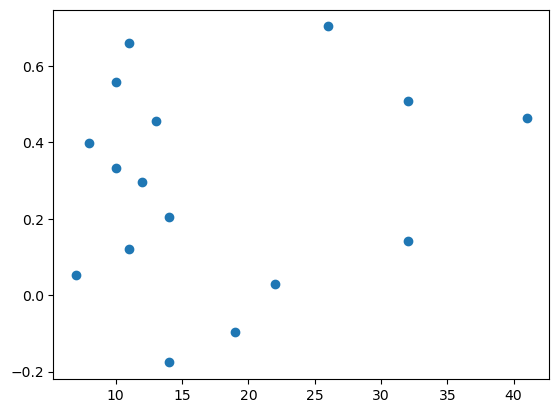

In [104]:
plt.scatter(x,cpe_y)

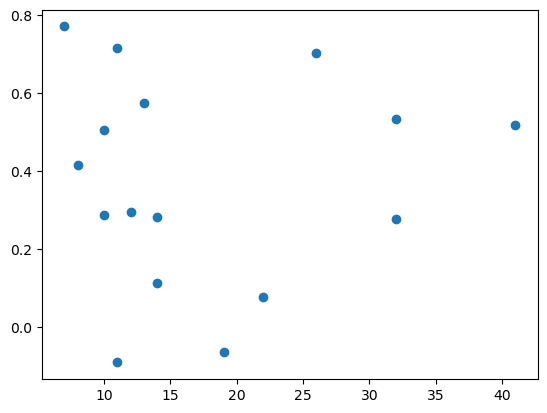

In [105]:
plt.scatter(x,regret_betas)

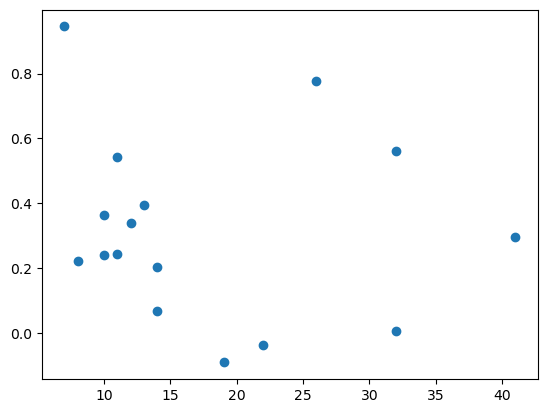

In [106]:
plt.scatter(x,relief_betas)

In [107]:
dep_regret_betas = regret_fits[dep_subj].iloc[-1]
nodep_regret_betas = regret_fits[nodep_subj].iloc[-1]

dep_cpe_betas = cpe_fits[dep_subj].iloc[-1]
nodep_cpe_betas = cpe_fits[nodep_subj].iloc[-1]

dep_relief_betas = relief_fits[dep_subj].iloc[-1]
nodep_relief_betas = relief_fits[nodep_subj].iloc[-1]

dep_full_regret_betas = full_fits[dep_subj].iloc[-2]
nodep_full_regret_betas = full_fits[nodep_subj].iloc[-2]

dep_full_relief_betas = full_fits[dep_subj].iloc[-1]
nodep_full_relief_betas = full_fits[nodep_subj].iloc[-1]

dep_full_rpe_betas = full_fits[dep_subj].iloc[-3]
nodep_full_rpe_betas = full_fits[nodep_subj].iloc[-3]


In [108]:
import scipy.stats as stats
stats.ttest_ind(dep_regret_betas, nodep_regret_betas, equal_var=False)


Ttest_indResult(statistic=0.5432402164654145, pvalue=0.6000214304533696)

In [109]:
stats.ttest_ind(dep_cpe_betas, nodep_cpe_betas, equal_var=False)


Ttest_indResult(statistic=0.7802967796339095, pvalue=0.45925297771105256)

In [110]:
stats.ttest_ind(dep_relief_betas, nodep_relief_betas, equal_var=False)


Ttest_indResult(statistic=0.028189275038133454, pvalue=0.9783948516446517)

In [111]:
stats.ttest_ind(dep_full_regret_betas, nodep_full_regret_betas, equal_var=False)


Ttest_indResult(statistic=1.524701829358518, pvalue=0.16625233011233456)

In [112]:
stats.ttest_ind(dep_full_relief_betas, nodep_full_relief_betas, equal_var=False)


Ttest_indResult(statistic=-0.1264751344389692, pvalue=0.901349592559612)

In [113]:
stats.ttest_ind(dep_full_rpe_betas, nodep_full_rpe_betas, equal_var=False)


Ttest_indResult(statistic=-1.4441534556894007, pvalue=0.17849490475536922)

## Prospect Theory GLMs

PT models - 

1) PT (Util_s+Util_g) *validate this is better than Rutledge EV (PT1)
2) RPE PT (Util_s+Util_g+RPE)
3) CPE PT (Util_s+Util_g+tCPE) *tCPE always now
4) CPE+RPE PT (Util_s+Util_g+RPE+tCPE) 
5) Regret PT (Util_s+Util_g+tRegret) *omit RPE if model 4 > model 5
6) Relief PT (Util_s+Util_g+tRelief) *omit RPE if model 4 > model 5
7) Regret/Relief PT (Util_s+Util_g+tRegret+tRelief) 
8) RPE Regret (Util_s+Util_g+RPE+tRegret)
9) RPE Relief (Util_s+Util_g+RPE+tRelief)
10) RPE Regret/Relief PT (Util_s+Util_g+RPE+tRegret+tRelief) 

GLM Comparison - 

1) Rutledge EV (CR+EV)
2) RPE (CR+EV+RPE)
3) Counterfactual (CR+EV+tCPE) 
4) Counterfactual+RPE (CR+EV+RPE+tCPE)
5) Regret (CR+EV+regret) 
6) Relief (CR+EV+relief)
7) Regret/Relief (CR+EV+regret+relief)
8) RPE/Regret (CR+EV+RPE+Regret)
9) RPE/Relief (CR+EV+RPE+Relief)
10) RPE/Regret/Relief (CR+EV+RPE+regret+relief)


In [116]:
pt1_vars = ["util_s(t-1)","util_s(t-2)","util_s(t-3)","util_g(t-1)","util_g(t-2)","util_g(t-3)"]
pt2_vars = ["util_s(t-1)","util_s(t-2)","util_s(t-3)","util_g(t-1)","util_g(t-2)","util_g(t-3)","rpe(t-1)","rpe(t-2)","rpe(t-3)"]
pt3_vars = ["util_s(t-1)","util_s(t-2)","util_s(t-3)","util_g(t-1)","util_g(t-2)","util_g(t-3)","totalcpe(t-1)","totalcpe(t-2)","totalcpe(t-3)"]
pt4_vars = ["util_s(t-1)","util_s(t-2)","util_s(t-3)","util_g(t-1)","util_g(t-2)","util_g(t-3)","rpe(t-1)","rpe(t-2)","rpe(t-3)","totalcpe(t-1)","totalcpe(t-2)","totalcpe(t-3)"]
pt5_vars = ["util_s(t-1)","util_s(t-2)","util_s(t-3)","util_g(t-1)","util_g(t-2)","util_g(t-3)","totalregret(t-1)","totalregret(t-2)","totalregret(t-3)"]
pt6_vars = ["util_s(t-1)","util_s(t-2)","util_s(t-3)","util_g(t-1)","util_g(t-2)","util_g(t-3)","totalrelief(t-1)","totalrelief(t-2)","totalrelief(t-3)"]
pt7_vars = ["util_s(t-1)","util_s(t-2)","util_s(t-3)","util_g(t-1)","util_g(t-2)","util_g(t-3)","totalregret(t-1)","totalregret(t-2)","totalregret(t-3)","totalrelief(t-1)","totalrelief(t-2)","totalrelief(t-3)"]
pt8_vars = ["util_s(t-1)","util_s(t-2)","util_s(t-3)","util_g(t-1)","util_g(t-2)","util_g(t-3)","rpe(t-1)","rpe(t-2)","rpe(t-3)","totalregret(t-1)","totalregret(t-2)","totalregret(t-3)"]
pt9_vars = ["util_s(t-1)","util_s(t-2)","util_s(t-3)","util_g(t-1)","util_g(t-2)","util_g(t-3)","rpe(t-1)","rpe(t-2)","rpe(t-3)","totalrelief(t-1)","totalrelief(t-2)","totalrelief(t-3)"]
pt10_vars = ["util_s(t-1)","util_s(t-2)","util_s(t-3)","util_g(t-1)","util_g(t-2)","util_g(t-3)","rpe(t-1)","rpe(t-2)","rpe(t-3)","totalregret(t-1)","totalregret(t-2)","totalregret(t-3)","totalrelief(t-1)","totalrelief(t-2)","totalrelief(t-3)"]


glm1_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)"]
glm2_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","rpe(t-1)","rpe(t-2)","rpe(t-3)"]
glm3_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","totalcpe(t-1)","totalcpe(t-2)","totalcpe(t-3)"]
glm4_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","rpe(t-1)","rpe(t-2)","rpe(t-3)","totalcpe(t-1)","totalcpe(t-2)","totalcpe(t-3)"]
glm5_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","totalregret(t-1)","totalregret(t-2)","totalregret(t-3)"]
glm6_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","totalrelief(t-1)","totalrelief(t-2)","totalrelief(t-3)"]
glm7_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","totalregret(t-1)","totalregret(t-2)","totalregret(t-3)","totalrelief(t-1)","totalrelief(t-2)","totalrelief(t-3)"]
glm8_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","rpe(t-1)","rpe(t-2)","rpe(t-3)","totalregret(t-1)","totalregret(t-2)","totalregret(t-3)"]
glm9_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","rpe(t-1)","rpe(t-2)","rpe(t-3)","totalrelief(t-1)","totalrelief(t-2)","totalrelief(t-3)"]
glm10_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","rpe(t-1)","rpe(t-2)","rpe(t-3)","totalregret(t-1)","totalregret(t-2)","totalregret(t-3)","totalrelief(t-1)","totalrelief(t-2)","totalrelief(t-3)"]


In [117]:
pt_glms_dict = {}
pt_glms_dict['Util'] = pt1_vars
pt_glms_dict['RPE'] = pt2_vars
pt_glms_dict['CPE'] = pt3_vars
pt_glms_dict['CPE_RPE'] = pt4_vars
pt_glms_dict['UtilReg'] = pt5_vars
pt_glms_dict['UtilRel'] = pt6_vars
pt_glms_dict['Reg_Rel'] = pt7_vars
pt_glms_dict['RPE_Reg'] = pt8_vars
pt_glms_dict['RPE_Rel'] = pt9_vars
pt_glms_dict['RPE_Reg_Rel'] = pt10_vars


In [118]:
glms_dict = {}
glms_dict['CR_EV'] = glm1_vars
glms_dict['RPE'] = glm2_vars
glms_dict['CPE'] = glm3_vars
glms_dict['CPE_RPE'] = glm4_vars
glms_dict['Regret'] = glm5_vars
glms_dict['Relief'] = glm6_vars
glms_dict['Regret_Relief'] = glm7_vars
glms_dict['RPE_Reg'] = glm8_vars
glms_dict['RPE_Rel'] = glm9_vars
glms_dict['RPE_Reg_Rel'] = glm10_vars


In [119]:
pt_list = ['Util','RPE','CPE','CPE_RPE','UtilReg','UtilRel','Reg_Rel','RPE_Reg','RPE_Rel','RPE_Reg_Rel']
glms_list = ['CR_EV','RPE','CPE','CPE_RPE','Regret','Relief','Regret_Relief','RPE_Reg','RPE_Rel','RPE_Reg_Rel']


In [121]:
#find optim PT params

lam_method = 'exp'
pt_results = {}

for model in pt_list:

    reg_list = pt_glms_dict[model]
    n_regs = int(len(reg_list)/3)

    mood_est_df, optim_resid_df, optim_inits_df, param_fits_df, aic_dict,bic1_dict,bic2_dict, rsq_dict = \
    SWB_modeling_utils.run_swb(model_input, subj_ids, n_regs, reg_list,lam_method)
    

    pt_results[model] = {'mood_est': mood_est_df,
                            'optim_residuals':optim_resid_df,
                           'optim_inits': optim_inits_df,
                           'param_fits': param_fits_df,
                            'aics':aic_dict,
                           'bics1': bic1_dict,
                            'bics2': bic2_dict,
                           'rsqs': rsq_dict
                           }

In [122]:

lam_method = 'exp'
glm_results = {}

for model in glms_list:

    reg_list = glms_dict[model]
    n_regs = int(len(reg_list)/3)

    mood_est_df, optim_resid_df, optim_inits_df, param_fits_df, aic_dict,bic1_dict,bic2_dict, rsq_dict = \
    SWB_modeling_utils.run_swb(model_input, subj_ids, n_regs, reg_list,lam_method)
    

    glm_results[model] = {'mood_est': mood_est_df,
                            'optim_residuals':optim_resid_df,
                           'optim_inits': optim_inits_df,
                           'param_fits': param_fits_df,
                            'aics':aic_dict,
                           'bics1': bic1_dict,
                            'bics2': bic2_dict,
                           'rsqs': rsq_dict
                           }

In [123]:
### use optimal parameters to run model 

pt_list = ['Util','RPE','CPE','CPE_RPE','UtilReg','UtilRel','Reg_Rel','RPE_Reg','RPE_Rel','RPE_Reg_Rel']
lam_method = 'exp'
pt_data = {}

for model in pt_list:

    reg_list = pt_glms_dict[model]
    n_regs = int(len(reg_list)/3)
    params = pt_results[model]['param_fits']

    mood_est_df, resid_df, rss_dict, aic_dict, bic1_dict, bic2_dict, rsq_dict = \
    SWB_modeling_utils.fit_swb(model_input,subj_ids,params,n_regs,reg_list,lam_method)
    

    pt_data[model] = {'mood_est': mood_est_df,
                            'residuals':resid_df,
                           'rss': rss_dict,
                            'aic':aic_dict,
                           'bics1': bic1_dict,
                            'bics2': bic2_dict,
                           'rsqs': rsq_dict
                           }


In [124]:
### use optimal parameters to run model 

glms_list = ['CR_EV','RPE','CPE','CPE_RPE','Regret','Relief','Regret_Relief','RPE_Reg','RPE_Rel','RPE_Reg_Rel']
lam_method = 'exp'
glm_data = {}

for model in glms_list:

    reg_list = glms_dict[model]
    n_regs = int(len(reg_list)/3)
    params = glm_results[model]['param_fits']

    mood_est_df, resid_df, rss_dict, aic_dict, bic1_dict, bic2_dict, rsq_dict = \
    SWB_modeling_utils.fit_swb(model_input,subj_ids,params,n_regs,reg_list,lam_method)
    

    glm_data[model] = {'mood_est': mood_est_df,
                            'residuals':resid_df,
                           'rss': rss_dict,
                            'aic':aic_dict,
                           'bics1': bic1_dict,
                            'bics2': bic2_dict,
                           'rsqs': rsq_dict
                           }


In [211]:
pt_data

{'Util': {'mood_est':           DA8       DA9      DA10      DA11     DA023     MS002     MS003  \
  0   -0.037337 -2.506241 -1.627253 -2.554567 -0.240460 -0.400959  0.260496   
  1   -0.010905 -0.252596 -1.471419 -1.929541 -0.617123 -0.138695 -0.710046   
  2    0.253531  0.206992  1.019775  0.680199  0.313904  0.418772  0.028980   
  3    0.024770  1.253870 -0.010358 -1.820611 -0.986637  0.517567 -1.460707   
  4    0.083282 -0.383504 -2.023673 -0.455347 -0.011550 -0.543448 -0.140152   
  ..        ...       ...       ...       ...       ...       ...       ...   
  795  0.204125 -0.097468  0.254796  0.276926  0.259656  0.216892  0.086287   
  796  0.125014  0.393410 -0.193669 -0.516660 -0.276096  0.114943 -0.621916   
  797  0.151286  0.609643  0.211063 -0.294763 -0.251899  0.238563 -0.664267   
  798  0.158195  0.297740  0.417972 -0.332730 -0.175520  0.276488 -0.502931   
  799  0.151984  0.477648 -0.123483 -0.179908 -0.113269  0.181752 -0.444859   
  
          MS016     MS017    

In [213]:
pt_list_noutil = ['RPE','CPE','CPE_RPE','UtilReg','UtilRel','Reg_Rel','RPE_Reg','RPE_Rel','RPE_Reg_Rel']

gl_list_nocr = ['RPE','CPE','CPE_RPE','Regret','Relief','Regret_Relief','RPE_Reg','RPE_Rel','RPE_Reg_Rel']


In [214]:
for ix,s in enumerate(subj_ids):
    best_pt_bic = np.inf
    best_bic = np.inf
    best_pt_model_bic = []
    best_model_bic = []
    for model in pt_list_noutil:
        bic1 = pt_data[model]['bics2'][s]
        if bic1<best_pt_bic:
            best_pt_bic = bic1 
            best_pt_model_bic = model
    for model in gl_list_nocr:
        bic = glm_data[model]['bics2'][s]
        if bic<best_bic:
            best_bic = bic 
            best_model_bic = model
        
    print('best pt model bic for ',s,'is',best_pt_model_bic,best_pt_bic)
    print('best model bic for ',s,'is',best_model_bic,best_bic)

best pt model bic for  DA8 is RPE 33.32790117349848
best model bic for  DA8 is Relief 33.496494001448
best pt model bic for  DA9 is CPE 32.77272459423
best model bic for  DA9 is Relief 33.75745526458038
best pt model bic for  DA10 is UtilReg 32.5116277514517
best model bic for  DA10 is Relief 33.78078458435115
best pt model bic for  DA11 is CPE 31.633452494566207
best model bic for  DA11 is Relief 34.031453160739886
best pt model bic for  DA023 is UtilReg 33.675694867820944
best model bic for  DA023 is CPE 33.89801369034184
best pt model bic for  MS002 is UtilRel 33.04516041438934
best model bic for  MS002 is RPE 33.94133945247566
best pt model bic for  MS003 is UtilReg 33.00373423363607
best model bic for  MS003 is Relief 34.03821345037194
best pt model bic for  MS016 is CPE 33.389934721253
best model bic for  MS016 is Relief 34.087290415248304
best pt model bic for  MS017 is UtilReg 33.167570600916434
best model bic for  MS017 is Relief 33.38716895075214
best pt model bic for  MS019 

In [ ]:
pt_list = ['Util','RPE','CPE','CPE_RPE','UtilReg','UtilRel','Reg_Rel','RPE_Reg','RPE_Rel','RPE_Reg_Rel']

glms_list = ['CR_EV','RPE','CPE','CPE_RPE','Regret','Relief','Regret_Relief','RPE_Reg','RPE_Rel','RPE_Reg_Rel']


In [127]:
pt_bic1_means = []
for model in pt_list:
    pt_bic1_means.append(np.mean(np.array(list(pt_data[model]['bics1'].values()))))
    print(model,'PT bic1 mean',np.mean(np.array(list(pt_data[model]['bics1'].values()))))

glm_bic1_means = []
for model in glms_list:
    glm_bic1_means.append(np.mean(np.array(list(glm_data[model]['bics1'].values()))))
    print(model,'GLM bic1 mean',np.mean(np.array(list(glm_data[model]['bics1'].values()))))

Util PT bic1 mean 236.63762810087877
RPE PT bic1 mean 185.30789925409414
CPE PT bic1 mean 271.0453577490722
CPE_RPE PT bic1 mean 301.3513484540854
UtilReg PT bic1 mean 278.8167247539411
UtilRel PT bic1 mean 206.8296589131022
Reg_Rel PT bic1 mean 319.6254622789154
RPE_Reg PT bic1 mean 311.3801432820499
RPE_Rel PT bic1 mean 243.9547488343944
RPE_Reg_Rel PT bic1 mean 350.68117815506906
CR_EV GLM bic1 mean -154.77042785505307
RPE GLM bic1 mean -146.16614021905113
CPE GLM bic1 mean -164.9914838153185
CPE_RPE GLM bic1 mean -122.6088936636323
Regret GLM bic1 mean -167.39165927686167
Relief GLM bic1 mean -135.4752592309149
Regret_Relief GLM bic1 mean -162.0115554192102
RPE_Reg GLM bic1 mean -127.07430335941874
RPE_Rel GLM bic1 mean -127.49003992033948
RPE_Reg_Rel GLM bic1 mean -108.62330090009993


In [128]:
pt_bic1_sum = []
for model in pt_list:
    pt_bic1_sum.append(np.sum(np.array(list(pt_data[model]['bics1'].values()))))
    print(model,'PT bic1 sum',np.sum(np.array(list(pt_data[model]['bics1'].values()))))

glm_bic1_sum = []
for model in glms_list:
    glm_bic1_sum.append(np.sum(np.array(list(glm_data[model]['bics1'].values()))))
    print(model,'GLM bic1 sum',np.sum(np.array(list(glm_data[model]['bics1'].values()))))

Util PT bic1 sum 3786.2020496140603
RPE PT bic1 sum 2964.926388065506
CPE PT bic1 sum 4336.725723985155
CPE_RPE PT bic1 sum 4821.621575265366
UtilReg PT bic1 sum 4461.067596063058
UtilRel PT bic1 sum 3309.2745426096353
Reg_Rel PT bic1 sum 5114.007396462646
RPE_Reg PT bic1 sum 4982.082292512799
RPE_Rel PT bic1 sum 3903.2759813503103
RPE_Reg_Rel PT bic1 sum 5610.898850481105
CR_EV GLM bic1 sum -2476.326845680849
RPE GLM bic1 sum -2338.658243504818
CPE GLM bic1 sum -2639.863741045096
CPE_RPE GLM bic1 sum -1961.7422986181168
Regret GLM bic1 sum -2678.266548429787
Relief GLM bic1 sum -2167.6041476946384
Regret_Relief GLM bic1 sum -2592.184886707363
RPE_Reg GLM bic1 sum -2033.1888537506998
RPE_Rel GLM bic1 sum -2039.8406387254317
RPE_Reg_Rel GLM bic1 sum -1737.972814401599


In [129]:
pt_bic2_means = []
for model in pt_list:
    pt_bic2_means.append(np.mean(np.array(list(pt_data[model]['bics2'].values()))))
    print(model,'PT bic2 mean',np.mean(np.array(list(pt_data[model]['bics2'].values()))))

glm_bic2_means = []
for model in glms_list:
    glm_bic2_means.append(np.mean(np.array(list(glm_data[model]['bics2'].values()))))
    print(model,'GLM bic2 mean',np.mean(np.array(list(glm_data[model]['bics2'].values()))))

Util PT bic2 mean 26.213698957696188
RPE PT bic2 mean 33.04334653680024
CPE PT bic2 mean 32.829002890562805
CPE_RPE PT bic2 mean 39.45456117078737
UtilReg PT bic2 mean 32.80957447305063
UtilRel PT bic2 mean 32.98954213765273
Reg_Rel PT bic2 mean 39.40887588622529
RPE_Reg PT bic2 mean 39.42948918371745
RPE_Rel PT bic2 mean 39.5980526698366
RPE_Reg_Rel PT bic2 mean 46.032559853522
CR_EV GLM bic2 mean 27.19221909758602
RPE GLM bic2 mean 33.87203163548311
CPE GLM bic2 mean 33.91909499447378
CPE_RPE GLM bic2 mean 40.51446177608166
Regret GLM bic2 mean 33.92509543312764
Relief GLM bic2 mean 33.84530443301277
Regret_Relief GLM bic2 mean 40.6129684304706
RPE_Reg GLM bic2 mean 40.525625300321124
RPE_Rel GLM bic2 mean 40.52666464172343
RPE_Reg_Rel GLM bic2 mean 47.180821051159924


In [130]:
pt_bic2_sum = []
for model in pt_list:
    pt_bic2_sum.append(np.sum(np.array(list(pt_data[model]['bics2'].values()))))
    print(model,'PT bic2 sum',np.sum(np.array(list(pt_data[model]['bics2'].values()))))

glm_bic2_sum = []
for model in glms_list:
    glm_bic2_sum.append(np.sum(np.array(list(glm_data[model]['bics2'].values()))))
    print(model,'GLM bic2 sum',np.sum(np.array(list(glm_data[model]['bics2'].values()))))

Util PT bic2 sum 419.419183323139
RPE PT bic2 sum 528.6935445888039
CPE PT bic2 sum 525.2640462490049
CPE_RPE PT bic2 sum 631.272978732598
UtilReg PT bic2 sum 524.9531915688101
UtilRel PT bic2 sum 527.8326742024436
Reg_Rel PT bic2 sum 630.5420141796046
RPE_Reg PT bic2 sum 630.8718269394792
RPE_Rel PT bic2 sum 633.5688427173856
RPE_Reg_Rel PT bic2 sum 736.520957656352
CR_EV GLM bic2 sum 435.0755055613763
RPE GLM bic2 sum 541.9525061677298
CPE GLM bic2 sum 542.7055199115805
CPE_RPE GLM bic2 sum 648.2313884173066
Regret GLM bic2 sum 542.8015269300422
Relief GLM bic2 sum 541.5248709282043
Regret_Relief GLM bic2 sum 649.8074948875296
RPE_Reg GLM bic2 sum 648.410004805138
RPE_Rel GLM bic2 sum 648.4266342675749
RPE_Reg_Rel GLM bic2 sum 754.8931368185588


In [131]:
pt_aic_means = []
for model in pt_list:
    pt_aic_means.append(np.mean(np.array(list(pt_data[model]['aic'].values()))))
    print(model,'PT aic mean',np.mean(np.array(list(pt_data[model]['aic'].values()))))

glm_aic_means = []
for model in glms_list:
    glm_aic_means.append(np.mean(np.array(list(glm_data[model]['aic'].values()))))
    print(model,'GLM aic mean',np.mean(np.array(list(glm_data[model]['aic'].values()))))

Util PT aic mean 217.89918119020706
RPE PT aic mean 161.8848406157545
CPE PT aic mean 247.62229911073257
CPE_RPE PT aic mean 273.2436780880778
UtilReg PT aic mean 255.39366611560146
UtilRel PT aic mean 183.40660027476258
Reg_Rel PT aic mean 291.5177919129078
RPE_Reg PT aic mean 283.2724729160424
RPE_Rel PT aic mean 215.84707846838685
RPE_Reg_Rel PT aic mean 317.88889606139355
CR_EV GLM aic mean -173.50887476572478
RPE GLM aic mean -169.58919885739078
CPE GLM aic mean -188.4145424536581
CPE_RPE GLM aic mean -150.71656402963987
Regret GLM aic mean -190.8147179152013
Relief GLM aic mean -158.89831786925453
Regret_Relief GLM aic mean -190.11922578521776
RPE_Reg GLM aic mean -155.1819737254263
RPE_Rel GLM aic mean -155.59771028634702
RPE_Reg_Rel GLM aic mean -141.41558299377542


In [132]:
pt_aic_sum = []
for model in pt_list:
    pt_aic_sum.append(np.sum(np.array(list(pt_data[model]['aic'].values()))))
    print(model,'PT aic sum',np.sum(np.array(list(pt_data[model]['aic'].values()))))

glm_aic_sum = []
for model in glms_list:
    glm_aic_sum.append(np.sum(np.array(list(glm_data[model]['aic'].values()))))
    print(model,'GLM aic mean',np.sum(np.array(list(glm_data[model]['aic'].values()))))

Util PT aic sum 3486.386899043313
RPE PT aic sum 2590.157449852072
CPE PT aic sum 3961.956785771721
CPE_RPE PT aic sum 4371.898849409245
UtilReg PT aic sum 4086.2986578496234
UtilRel PT aic sum 2934.5056043962013
Reg_Rel PT aic sum 4664.284670606525
RPE_Reg PT aic sum 4532.359566656678
RPE_Rel PT aic sum 3453.5532554941897
RPE_Reg_Rel PT aic sum 5086.222336982297
CR_EV GLM aic mean -2776.1419962515965
RPE GLM aic mean -2713.4271817182525
CPE GLM aic mean -3014.6326792585296
CPE_RPE GLM aic mean -2411.465024474238
Regret GLM aic mean -3053.035486643221
Relief GLM aic mean -2542.3730859080724
Regret_Relief GLM aic mean -3041.9076125634842
RPE_Reg GLM aic mean -2482.911579606821
RPE_Rel GLM aic mean -2489.5633645815524
RPE_Reg_Rel GLM aic mean -2262.6493279004067


plot residuals of functions 

Model 2: Dual Risk 

In [ ]:
### use optimal parameters to run model 

pt_list = ['Util','RPE','CPE','CPE_RPE','UtilReg','UtilRel','Reg_Rel','RPE_Reg','RPE_Rel','RPE_Reg_Rel']
lam_method = 'exp'
pt_data = {}

for model in pt_list:

    reg_list = pt_glms_dict[model]
    n_regs = int(len(reg_list)/3)
    params = pt_results[model]['param_fits']

    mood_est_df, resid_df, rss_dict, aic_dict, bic1_dict, bic2_dict, rsq_dict = \
    SWB_modeling_utils.fit_swb(model_input,subj_ids,params,n_regs,reg_list,lam_method)
    

    pt_data[model] = {'mood_est': mood_est_df,
                            'residuals':resid_df,
                           'rss': rss_dict,
                            'aic':aic_dict,
                           'bics1': bic1_dict,
                            'bics2': bic2_dict,
                           'rsqs': rsq_dict
                           }


# PT Params with BDI

In [135]:
bdi_info = pd.read_excel(f'{swb_dir}SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[3,4])
swb_bdi_list = list(bdi_info.SWB_BDI)
np_bdi_list = list(bdi_info.BDI)

In [155]:
swb_bdi_list

[13, 32, 11, 41, 14, 14, 8, 10, 26, 12, 10, 7, 11, 22, 32, 19]

In [139]:
pt_params_df= pd.read_csv('/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/swb_computational_modeling/swb_behav_models/data/swb_base_pt_params.csv')

In [141]:
pt_params_df['swb_bdi'] = swb_bdi_list
pt_params_df['np_bdi'] = np_bdi_list

In [142]:
pt_params_df

,PatientID,Risk_Aversion,Loss_Aversion,Inverse_Temperature,swb_bdi,np_bdi
0,DA8,1.212121,5.111118,2.625557,13,13
1,DA9,1.484386,0.836855,3.261052,32,32
2,DA10,0.781768,1.727190,3.058603,11,11
3,DA11,1.199625,0.226255,1.527750,41,41
4,DA023,0.994608,1.864381,2.089041,14,14
5,MS002,0.818264,3.179061,1.528016,14,14
6,MS003,0.733145,0.001000,5.118690,8,6
7,MS016,0.623760,0.969737,6.760218,10,0
8,MS017,1.325976,0.989178,6.336838,26,29
9,MS019,1.140644,0.001000,6.780384,12,13


In [ ]:
pt_list = ['Util','RPE','CPE','CPE_RPE','UtilReg','UtilRel','Reg_Rel','RPE_Reg','RPE_Rel','RPE_Reg_Rel']

In [144]:
pt_results['CPE']['param_fits']

,DA8,DA9,DA10,DA11,DA023,MS002,MS003,MS016,MS017,MS019,MS022,MS025,MS026,MS027,MS029,MS030
0,0.171340,0.072487,0.354708,4.876799e-19,1.000000,0.856688,1.664079e-16,0.261294,0.255569,0.335089,0.091675,0.417869,1.000000,1.000000,0.433918,9.552593e-17
1,0.708307,0.547028,0.746319,1.690039e-01,0.201820,0.414120,-3.125438e-02,0.165853,0.614298,-0.001985,0.128026,0.366521,0.226285,0.118272,0.173142,6.155183e-02
2,0.086227,-1.246497,0.059987,-3.404675e-01,-0.043391,-0.155890,7.372084e-01,0.112377,-0.047650,0.412159,3.736717,0.279703,0.212023,-0.337535,0.323971,5.378479e-01
3,-0.016427,0.818168,0.421719,1.094101e+00,0.056284,0.185387,3.357622e-02,0.273431,0.375108,0.477529,-0.171159,-0.097489,-0.047033,0.287910,0.372680,-4.211364e-01
4,0.798186,0.585450,0.531952,5.795859e-01,0.109854,0.093518,4.241566e-01,0.307406,0.706123,0.295127,0.528214,0.175843,0.116089,0.014636,0.197988,-1.018461e-01


In [145]:
util_fits = pt_results['Util']['param_fits'] 
rpe_fits = pt_results['RPE']['param_fits'] 
cpe_fits = pt_results['CPE']['param_fits'] 
cpe_rpe_fits = pt_results['CPE_RPE']['param_fits'] 
regret_fits = pt_results['UtilReg']['param_fits'] 
relief_fits = pt_results['UtilRel']['param_fits'] 
reg_rel_fits = pt_results['Reg_Rel']['param_fits'] 
rpe_reg_fits = pt_results['RPE_Reg']['param_fits'] 
rpe_rel_fits = pt_results['RPE_Rel']['param_fits'] 
rpe_reg_rel_fits = pt_results['RPE_Reg_Rel']['param_fits'] 

In [151]:
util_fits

,DA8,DA9,DA10,DA11,DA023,MS002,MS003,MS016,MS017,MS019,MS022,MS025,MS026,MS027,MS029,MS030
0,0.109938,0.165124,0.511086,1.111957e-19,1.348999e-16,1.000000,1.917530e-19,0.363836,0.724420,0.997382,0.318743,0.403484,0.145579,1.000000,0.423202,2.051334e-17
1,0.178914,0.097486,0.291534,-3.948930e-02,3.379698e-02,0.227056,-2.195210e-01,-0.112674,0.039380,-0.314457,-0.232347,0.169491,0.017417,0.095655,-0.071803,1.294704e-01
2,-0.000546,-1.402404,-0.110339,-1.765902e-01,3.552507e-01,-0.141384,7.503986e-01,0.240015,0.219351,0.444627,3.546439,0.273105,0.646258,-0.331553,0.404121,5.480459e-01
3,0.062519,0.742113,0.502410,7.484754e-01,8.161764e-02,0.147485,-1.428509e-01,0.010816,0.151426,0.135376,-0.247973,-0.096501,-0.183495,0.270773,0.209376,-4.307828e-01


In [152]:
util_s_weights = util_fits.iloc[2]
util_g_weights = util_fits.iloc[3]
rpe_weights = rpe_fits.iloc[-1]
cpe_weights = cpe_fits.iloc[-1]
cpe_rpe_weights = cpe_rpe_fits.iloc[-1]
regret_weights = regret_fits.iloc[-1]
relief_weights = relief_fits.iloc[-1]
reg_rel_weights = reg_rel_fits.iloc[-1]
rel_reg_weights = reg_rel_fits.iloc[-2]
reg_rpe_rel_weights = rpe_reg_rel_fits.iloc[-2]



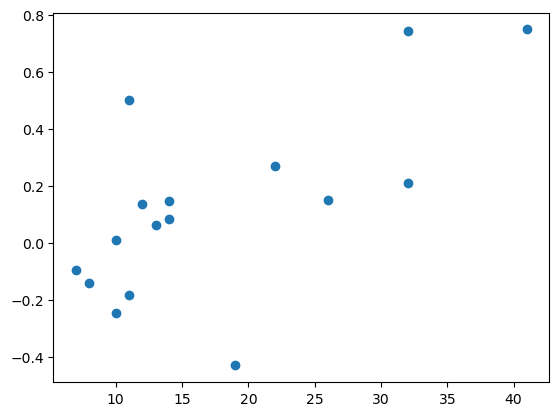

In [160]:
plt.scatter(swb_bdi_list,util_g_weights)

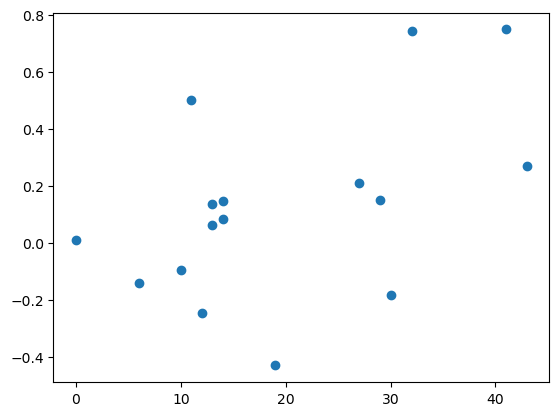

In [161]:
plt.scatter(np_bdi_list,util_g_weights)

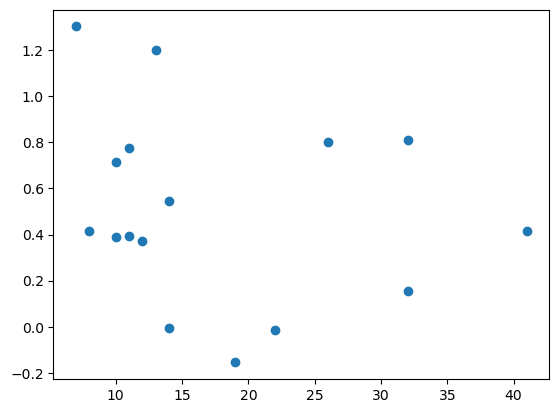

In [164]:
plt.scatter(swb_bdi_list,rpe_weights)

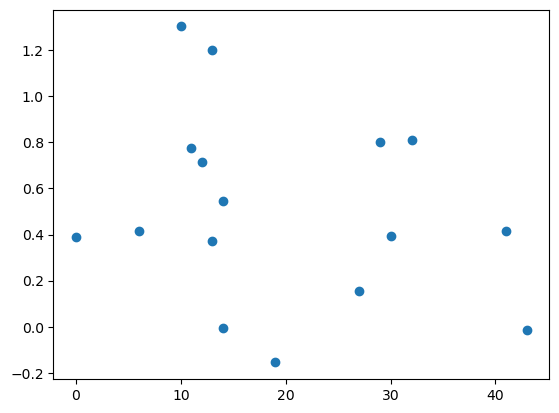

In [162]:
plt.scatter(np_bdi_list,rpe_weights)

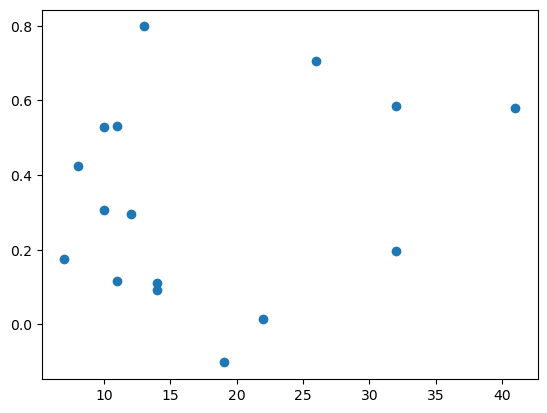

In [165]:
plt.scatter(swb_bdi_list,cpe_weights)

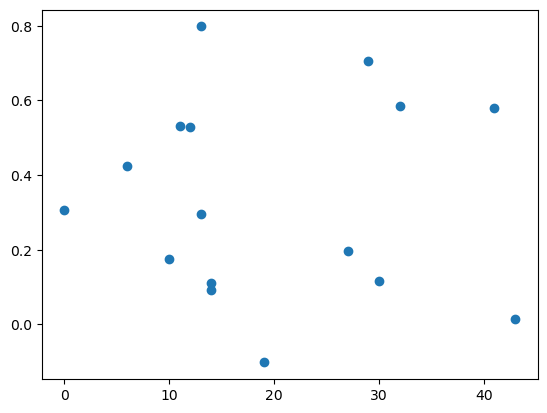

In [166]:
plt.scatter(np_bdi_list,cpe_weights)

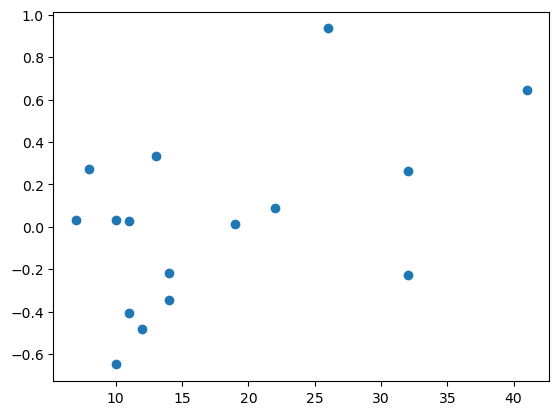

In [168]:
plt.scatter(swb_bdi_list,cpe_rpe_weights)

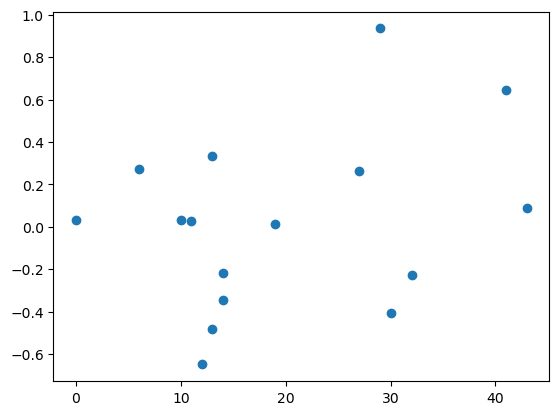

In [169]:
plt.scatter(np_bdi_list,cpe_rpe_weights)

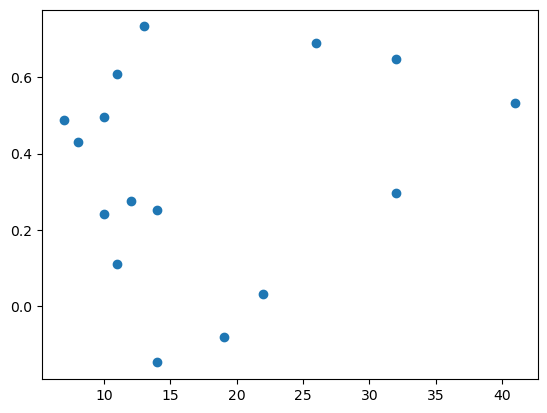

In [170]:
plt.scatter(swb_bdi_list,regret_weights)

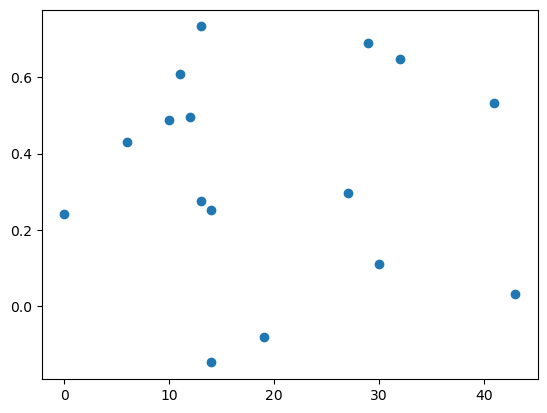

In [171]:
plt.scatter(np_bdi_list,regret_weights)

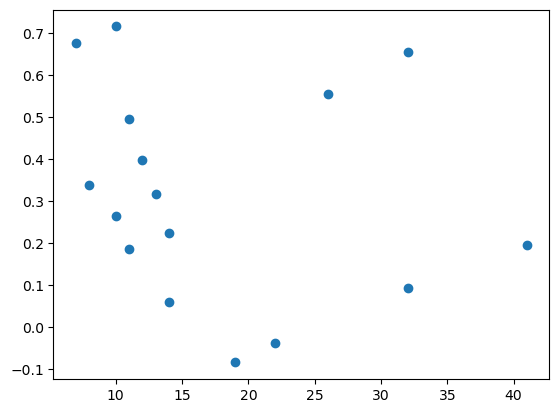

In [172]:
plt.scatter(swb_bdi_list,relief_weights)

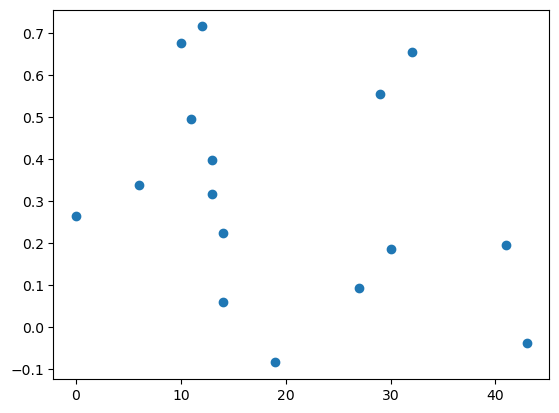

In [173]:
plt.scatter(np_bdi_list,relief_weights)

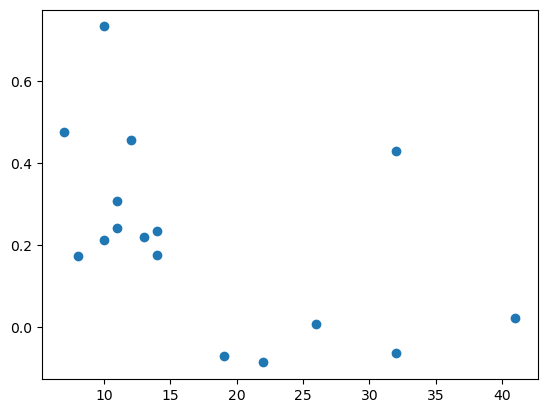

In [174]:
plt.scatter(swb_bdi_list,reg_rel_weights)

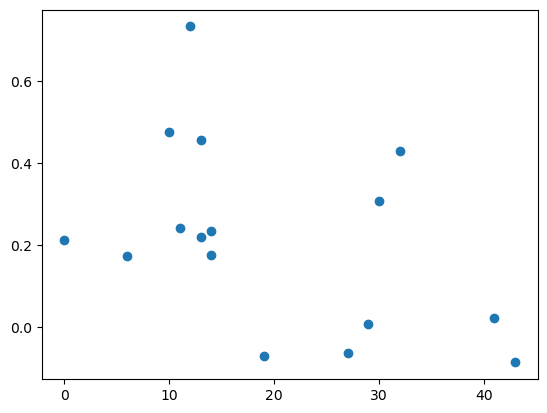

In [175]:
plt.scatter(np_bdi_list,reg_rel_weights)

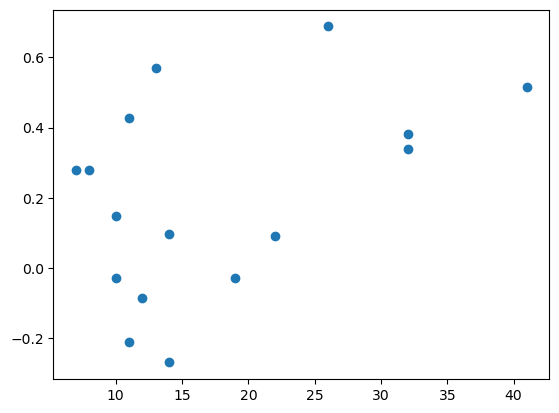

In [176]:
plt.scatter(swb_bdi_list,rel_reg_weights)

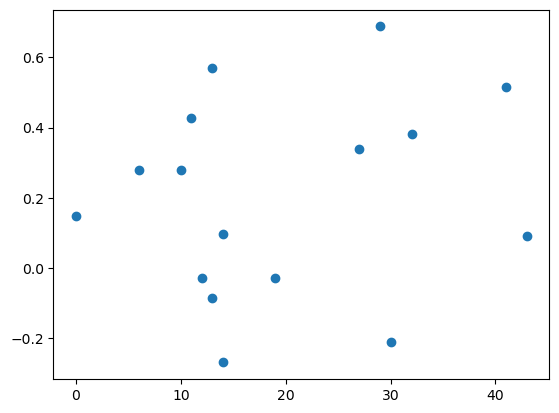

In [178]:
plt.scatter(np_bdi_list,rel_reg_weights)

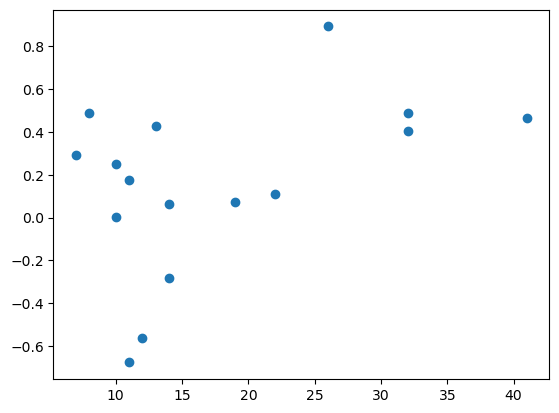

In [179]:
plt.scatter(swb_bdi_list,reg_rpe_rel_weights)

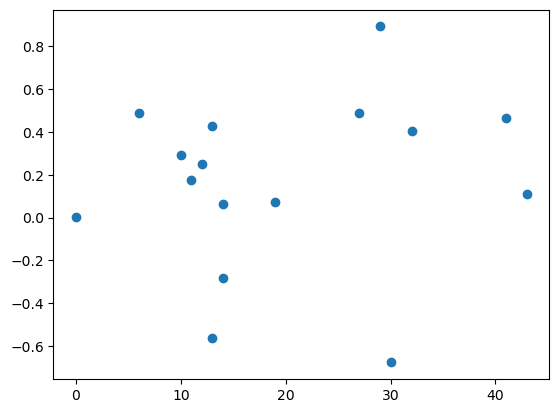

In [180]:
plt.scatter(np_bdi_list,reg_rpe_rel_weights)

In [181]:
pt_params_df

,PatientID,Risk_Aversion,Loss_Aversion,Inverse_Temperature,swb_bdi,np_bdi
0,DA8,1.212121,5.111118,2.625557,13,13
1,DA9,1.484386,0.836855,3.261052,32,32
2,DA10,0.781768,1.727190,3.058603,11,11
3,DA11,1.199625,0.226255,1.527750,41,41
4,DA023,0.994608,1.864381,2.089041,14,14
5,MS002,0.818264,3.179061,1.528016,14,14
6,MS003,0.733145,0.001000,5.118690,8,6
7,MS016,0.623760,0.969737,6.760218,10,0
8,MS017,1.325976,0.989178,6.336838,26,29
9,MS019,1.140644,0.001000,6.780384,12,13


(array([1., 0., 0., 4., 3., 2., 3., 2., 0., 1.]),
 array([1.00000000e-03, 1.93044823e-01, 3.85089646e-01, 5.77134469e-01,
        7.69179292e-01, 9.61224115e-01, 1.15326894e+00, 1.34531376e+00,
        1.53735858e+00, 1.72940341e+00, 1.92144823e+00]),
 <BarContainer object of 10 artists>)

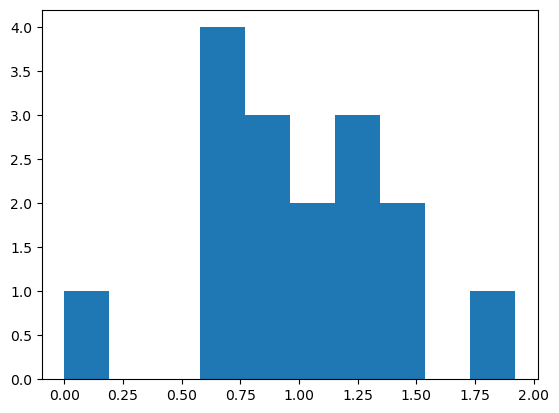

In [182]:
plt.hist(pt_params_df.Risk_Aversion)

(array([9., 4., 0., 1., 0., 1., 0., 0., 0., 1.]),
 array([1.0000e-03, 1.0009e+00, 2.0008e+00, 3.0007e+00, 4.0006e+00,
        5.0005e+00, 6.0004e+00, 7.0003e+00, 8.0002e+00, 9.0001e+00,
        1.0000e+01]),
 <BarContainer object of 10 artists>)

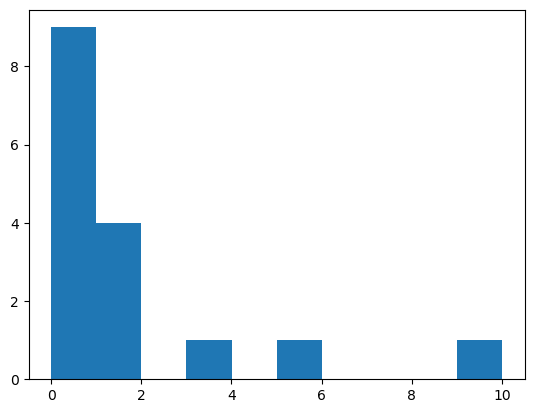

In [183]:
plt.hist(pt_params_df.Loss_Aversion)

In [186]:
swbdep_df = pt_params_df[pt_params_df.swb_bdi>=20]
noswbdep_df = pt_params_df[pt_params_df.swb_bdi<20]

In [187]:
npdep_df = pt_params_df[pt_params_df.swb_bdi>=20]
nonpdep_df = pt_params_df[pt_params_df.swb_bdi<20]

In [201]:
npdep_df

,PatientID,Risk_Aversion,Loss_Aversion,Inverse_Temperature,swb_bdi,np_bdi
1,DA9,1.484386,0.836855,3.261052,32,32
3,DA11,1.199625,0.226255,1.527750,41,41
8,MS017,1.325976,0.989178,6.336838,26,29
13,MS027,0.641948,0.648616,5.595923,22,43
14,MS029,0.001000,0.603489,0.723385,32,27


In [202]:
nonpdep_df

,PatientID,Risk_Aversion,Loss_Aversion,Inverse_Temperature,swb_bdi,np_bdi
0,DA8,1.212121,5.111118,2.625557,13,13
2,DA10,0.781768,1.727190,3.058603,11,11
4,DA023,0.994608,1.864381,2.089041,14,14
5,MS002,0.818264,3.179061,1.528016,14,14
6,MS003,0.733145,0.001000,5.118690,8,6
7,MS016,0.623760,0.969737,6.760218,10,0
9,MS019,1.140644,0.001000,6.780384,12,13
10,MS022,1.921448,0.102132,3.493744,10,12
11,MS025,0.887061,10.000000,0.657655,7,10
12,MS026,1.442294,1.728298,1.999431,11,30


In [203]:
import scipy.stats as stats
stats.ttest_ind(npdep_df.Loss_Aversion, nonpdep_df.Loss_Aversion, equal_var=False)


Ttest_indResult(statistic=-1.8744680163793896, pvalue=0.08917564514500789)

In [205]:
import scipy.stats as stats
stats.ttest_ind(swbdep_df.Loss_Aversion, noswbdep_df.Loss_Aversion, equal_var=False)

Ttest_indResult(statistic=-1.8744680163793896, pvalue=0.08917564514500789)

In [193]:
swbdep_df.Risk_Aversion.mean()

0.9305868310877967

In [192]:
noswbdep_df.Risk_Aversion.mean()

1.0261758053185503

In [194]:
swbdep_df.Loss_Aversion.mean()

0.6608786965367843

In [195]:
noswbdep_df.Loss_Aversion.mean()

2.3480158109202387

In [199]:
npdep_df.Risk_Aversion.mean()

0.9305868310877967

In [198]:
nonpdep_df.Risk_Aversion.mean()

1.0261758053185503

In [196]:
npdep_df.Loss_Aversion.mean()

0.6608786965367843

In [197]:
nonpdep_df.Loss_Aversion.mean()

2.3480158109202387

# Model Figures

In [ ]:
#model comparison fig
rutledge_bic1 = np.array(list(cf_results_dict['rutledge']['bics1'].values()))
total_cpe_bic1 = np.array(list(cf_results_dict['total_cpe']['bics1'].values()))
regret_bic1 = np.array(list(cf_results_dict['regret']['bics1'].values()))
relief_bic1 = np.array(list(cf_results_dict['relief']['bics1'].values()))
combo_bic1 = np.array(list(cf_results_dict['combo']['bics1'].values()))

In [ ]:
bar_data = pd.DataFrame(columns=['RPE','CPE','Regret','Relief','CPE Split'])
bar_data['RPE'] = rutledge_bic1
bar_data['CPE'] = total_cpe_bic1
bar_data['Regret'] = regret_bic1
bar_data['Relief'] = relief_bic1
bar_data['CPE Split'] = combo_bic1

In [ ]:
#magma,cubehelix,twilight
fig,ax = plt.subplots(figsize=(10,6))
sns.set_theme(style='whitegrid',font='Arial') 
sns.barplot(data=bar_data, errorbar=('ci',50),order=['Relief','Regret','RPE','CPE'],saturation=0.8,palette='flare',capsize=0.05,errcolor='black',errwidth=1.5)#flare_r,flare,Reds,YlOrRd, rocket
ax.set_title('SWB Model Evaluation',weight='semibold',fontsize=18,y=1.025)
#ax.set_xlabel('SWB Models',weight='medium',fontsize=15)
ax.set_ylabel('Mean BIC Score',weight='medium',fontsize=15,x=0.025)
ax.tick_params(labelsize=12)




In [ ]:
mood_est = list(pd.DataFrame.mean(cf_results_dict['total_cpe']['mood_est'],axis=1))

(-1.25, 1.25)

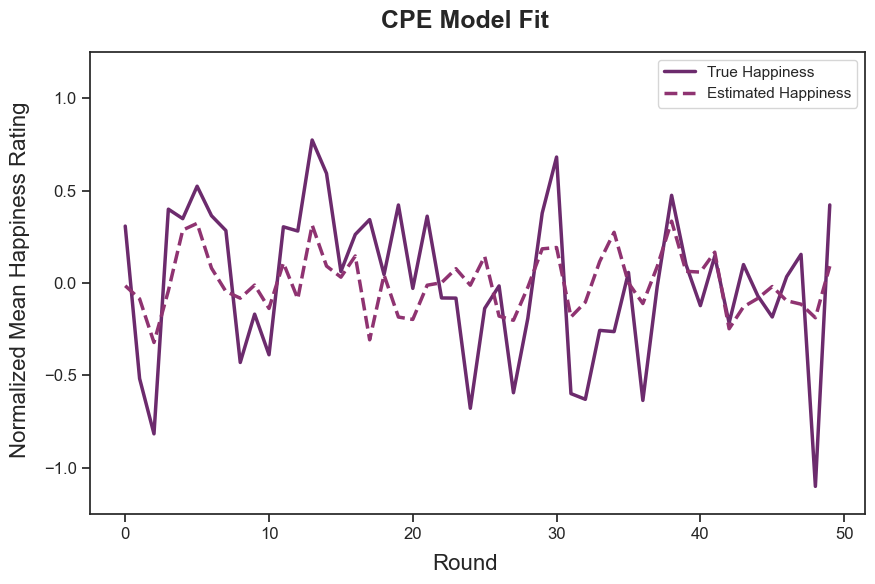

In [ ]:
fig,ax = plt.subplots(figsize=(10,6))
sns.set_theme(style='ticks',font='Arial',palette='flare_r') 
sns.lineplot(x=np.arange(0,50), y=rate_means[:50],label='True Happiness',linewidth=2.5)
sns.lineplot(x=np.arange(0,50), y=mood_est[:50],label='Estimated Happiness',linestyle='dashed',linewidth=2.5)
fig.suptitle('CPE Model Fit',font='Arial',weight ='semibold',fontsize=18,y=0.95)
fig.supxlabel('Round',font='Arial',fontsize=16,y=0.01)
fig.supylabel('Normalized Mean Happiness Rating',font='Arial',fontsize=16,x=0.045)
ax.tick_params(labelsize=12)
ax.set_ylim(-1.25,1.25)



In [ ]:
lams = cf_results_dict['combo']['param_fits'].iloc[0]
b_cr = cf_results_dict['combo']['param_fits'].iloc[2]
b_ev = cf_results_dict['combo']['param_fits'].iloc[3]
b_reg = cf_results_dict['combo']['param_fits'].iloc[4]
b_rel = cf_results_dict['combo']['param_fits'].iloc[5]
l = np.mean(np.array(lams))
cr = np.mean(np.array(b_cr))
ev = np.mean(np.array(b_ev))
reg = np.mean(np.array(b_reg))
rel = np.mean(np.array(b_rel))
import itertools

weights_plot_df = pd.DataFrame(columns=['trial','Regressor','Weight_Estimate'])
weights_plot_df['trial'] = ['t1','t2','t3']*4
weights_plot_df['Regressor'] = list(itertools.chain.from_iterable([['Certain Reward']*3,['Expected Value']*3,['Regret']*3,['Relief']*3]))



#cr
cr_t1 = cr
cr_t2 = cr*l
cr_t3 = cr*(l**2)

#ev
ev_t1 = ev
ev_t2 = ev*l
ev_t3 = ev*(l**2)

#reg
reg_t1 = reg
reg_t2 = reg*l
reg_t3 = reg*(l**2)

#rel
rel_t1 = rel
rel_t2 = rel*l
rel_t3 = rel*(l**2)

weights_plot_df['Weight_Estimate'] = [cr_t1,cr_t2,cr_t3,ev_t1,ev_t2,ev_t3,reg_t1,reg_t2,reg_t3,rel_t1,rel_t2,rel_t3]


In [ ]:
#weights plot
fig,(ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(17,5),sharey=True)
sns.set_theme(style='white',font='Arial') 
ax3.tick_params(labelsize=12)
sns.barplot(ax=ax1,data=weights_plot_df[weights_plot_df['Regressor']== 'Regret'],x='trial',y='Weight_Estimate',palette='Reds_r')
sns.barplot(ax=ax2,data=weights_plot_df[weights_plot_df['Regressor']== 'Relief'],x='trial',y='Weight_Estimate',palette='ocean_r')
sns.barplot(ax=ax3,data=weights_plot_df[weights_plot_df['Regressor']== 'Expected Value'],x='trial',y='Weight_Estimate',palette='YlGn_r')
sns.barplot(ax=ax4,data=weights_plot_df[weights_plot_df['Regressor']== 'Certain Reward'],x='trial',y='Weight_Estimate',palette='Purples_r')
ax1.set_ylim(0,0.65)
ax1.set_ylabel(None)
ax1.set_xlabel(None)
ax1.tick_params(labelsize=12)
ax1.set_title('Regret',weight='medium',fontsize=14,y=1.02)

ax2.set_ylabel(None)
ax2.set_xlabel(None)
ax2.tick_params(labelsize=12)
ax2.set_title('Relief',weight='medium',fontsize=14,y=1.02)

ax3.set_ylabel(None)
ax3.set_xlabel(None)
ax3.tick_params(labelsize=12)
ax3.set_title('Expected Value',weight='medium',fontsize=14,y=1.02)

ax4.set_ylabel(None)
ax4.set_xlabel(None)
ax4.tick_params(labelsize=12)
ax4.set_title('Certain Reward',weight='medium',fontsize=14,y=1.02)

fig.suptitle('Model Estimates of Regressor Weights',weight='semibold',fontsize=18, y=1.025)
fig.supxlabel('Count of Trials Preceeding Happiness Rating',weight='medium',fontsize=16,y=0.01)
fig.supylabel('Weight Estimate',weight='medium',fontsize=16,x=0.085)




In [ ]:
#weights plot
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5),sharey=True)
sns.set_theme(style='white',font='Arial') 
ax3.tick_params(labelsize=12)
sns.barplot(ax=ax1,data=weights_plot_df[weights_plot_df['Regressor']== 'Regret'],x='trial',y='Weight_Estimate',palette='flare_r')
sns.barplot(ax=ax2,data=weights_plot_df[weights_plot_df['Regressor']== 'Relief'],x='trial',y='Weight_Estimate',palette='BuGn_r')

ax1.set_ylim(0,0.65)
ax1.set_ylabel(None)
ax1.set_xlabel(None)
ax1.tick_params(labelsize=12)
ax1.set_title('Regret',weight='medium',fontsize=14,y=1.02)

ax2.set_ylabel(None)
ax2.set_xlabel(None)
ax2.tick_params(labelsize=12)
ax2.set_title('Relief',weight='medium',fontsize=14,y=1.02)

fig.suptitle('Weight of Counterfactual Prediction Errors on Happiness Ratings',weight='semibold',fontsize=18, y=1.025)
fig.supxlabel('Count of Trials Preceeding Happiness Rating',weight='medium',fontsize=16)
fig.supylabel('Weight Estimate',weight='medium',fontsize=16,x=0.05)




In [ ]:
fig,ax = plt.subplots(1,4,figsize=(10,6))
sns.set_theme(style='whitegrid',font='Arial') 
sns.barplot(data=bar_data, errorbar=('ci',50),order=['CPE Split','Relief','Regret','RPE','CPE'],saturation=0.8,palette='flare',capsize=0.05,errcolor='black',errwidth=1.5)#flare_r,flare,Reds,YlOrRd, rocket
ax.set_title('SWB Model Evaluation',weight='semibold',fontsize=18,y=1.025)
#ax.set_xlabel('SWB Models',weight='medium',fontsize=15)
ax.set_ylabel('Mean BIC Score',weight='medium',fontsize=15,x=0.025)
ax.tick_params(labelsize=12)


In [ ]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(12,5))
sns.set_theme(style='ticks',font='Arial',palette='mako_r') #magma_r,gnuplot,paired,cubehelix_r
sns.regplot(data=gamble_plot,ax=ax1,x='loss_x',y='loss_y',ci=68,logistic=True,scatter=False)
sns.regplot(data=gamble_plot,ax=ax2,x='mix_x',y='mix_y',ci=68,logistic=True,scatter=False)
sns.regplot(data=gamble_plot,ax=ax3,x='gain_x',y='gain_y',ci=68,logistic=True,scatter=False)
ax1.set_ylim(0,1)
ax1.set_ylabel(None)
ax1.set_xlabel(None)
ax1.tick_params(labelsize=12)
ax1.set_title('Loss Trials',weight='medium',fontsize=15,y=1.02)
ax2.set_ylim(0,1)
ax2.set_ylabel(None)
ax2.set_xlabel(None)
ax2.tick_params(labelsize=12)
ax2.set_title('Mix Trials',weight='medium',fontsize=15,y=1.02)
ax3.set_ylim(0,1)
ax3.set_ylabel(None)
ax3.set_xlabel(None)
ax3.tick_params(labelsize=12)
ax3.set_title('Gain Trials',weight='medium',fontsize=15,y=1.02)
fig.supxlabel('Normalized Expected Value',y=-0.025,weight='medium',fontsize=16)
fig.supylabel('Proportion of Gamble Choices',x=0.05,weight='medium',fontsize=16)
fig.suptitle('Influence of Expected Value on Gamble Decision',y=1.05,weight='semibold',fontsize=18)

References:
- https://shawnrhoads.github.io/gu-psyc-347/module-02-01_Nonlinear-Modeling.html
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html
- https://hernandis.me/2020/04/05/three-examples-of-nonlinear-least-squares-fitting-in-python-with-scipy.html
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.OptimizeResult.html#scipy.optimize.OptimizeResult
- https://www.nedcharles.com/regression/Nonlinear_Least_Squares_Regression_For_Python.html
